In [5]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import torch
import os

In [6]:
# 設置環境變量以啟用 MPS 後備
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# 檢查 MPS 是否可用
device = (
    "mps" 
    if torch.backends.mps.is_available() 
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [7]:
# 讀取CSV文件
df = pd.read_csv('../input/training_balanced.csv')
df = df.rename(columns={'HasTransaction': 'labels'})

# 將數據分為訓練集和驗證集
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 將DataFrame轉換為Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [8]:
display(train_dataset)

Dataset({
    features: ['Content', 'labels', '__index_level_0__'],
    num_rows: 314
})

In [9]:
display(val_dataset)

Dataset({
    features: ['Content', 'labels', '__index_level_0__'],
    num_rows: 79
})

In [10]:
# 設置tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
def preprocess_function(examples):
    # 為T5添加特定的前綴
    inputs = [f"classify transaction: {text}" for text in examples["Content"]]
    # 將標籤轉換為文本格式
    targets = [str(label) for label in examples["labels"]]
    
    model_inputs = tokenizer(
        inputs, 
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    # 對標籤進行編碼
    labels = tokenizer(
        targets,
        max_length=8,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
# 對數據集應用預處理
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

In [13]:
display(tokenized_train)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 314
})

In [14]:
display(tokenized_val)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 79
})

In [15]:
# 設置基礎模型
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
).to(device)

In [16]:
# 配置LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # T5是序列到序列模型
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q", "v"]  # T5的目標模塊
)

In [17]:
# 創建PEFT模型
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

trainable params: 884,736 || all params: 248,462,592 || trainable%: 0.3561


In [18]:
# 定義訓練參數
training_args = TrainingArguments(
    output_dir="./output/lora_results",
    num_train_epochs=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    auto_find_batch_size=True
)

In [19]:
# 設置Trainer並開始訓練
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

# 訓練前禁用快取以避免警告
model.config.use_cache = False

In [36]:
# 訓練模型
train_result = trainer.train()

  0%|          | 10/3900 [00:17<1:22:04,  1.27s/it]

{'loss': 19.8508, 'grad_norm': 13.790190696716309, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.25}


  1%|          | 20/3900 [00:28<1:13:13,  1.13s/it]

{'loss': 19.5617, 'grad_norm': 14.714408874511719, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.51}


  1%|          | 30/3900 [00:40<1:13:18,  1.14s/it]

{'loss': 19.7961, 'grad_norm': 11.885260581970215, 'learning_rate': 6.000000000000001e-07, 'epoch': 0.76}


  1%|          | 39/3900 [00:55<1:20:10,  1.25s/it]

{'eval_loss': 17.4375, 'eval_runtime': 4.0025, 'eval_samples_per_second': 19.738, 'eval_steps_per_second': 4.997, 'epoch': 0.99}


  1%|          | 40/3900 [00:57<2:55:19,  2.73s/it]

{'loss': 19.4, 'grad_norm': 14.05147933959961, 'learning_rate': 8.000000000000001e-07, 'epoch': 1.01}


  1%|▏         | 50/3900 [01:08<1:15:18,  1.17s/it]

{'loss': 20.0211, 'grad_norm': 13.29261589050293, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.27}


  2%|▏         | 60/3900 [01:20<1:12:21,  1.13s/it]

{'loss': 19.7328, 'grad_norm': 11.498863220214844, 'learning_rate': 1.2000000000000002e-06, 'epoch': 1.52}


  2%|▏         | 70/3900 [01:31<1:13:52,  1.16s/it]

{'loss': 19.482, 'grad_norm': 12.291247367858887, 'learning_rate': 1.4000000000000001e-06, 'epoch': 1.77}


  2%|▏         | 79/3900 [01:45<1:18:14,  1.23s/it]

{'eval_loss': 17.3125, 'eval_runtime': 3.4408, 'eval_samples_per_second': 22.96, 'eval_steps_per_second': 5.813, 'epoch': 2.0}


  2%|▏         | 80/3900 [01:47<2:36:47,  2.46s/it]

{'loss': 19.9031, 'grad_norm': 12.902595520019531, 'learning_rate': 1.6000000000000001e-06, 'epoch': 2.03}


  2%|▏         | 90/3900 [01:59<1:12:59,  1.15s/it]

{'loss': 19.3906, 'grad_norm': 13.789620399475098, 'learning_rate': 1.8000000000000001e-06, 'epoch': 2.28}


  3%|▎         | 100/3900 [02:10<1:11:11,  1.12s/it]

{'loss': 19.5141, 'grad_norm': 12.916407585144043, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.53}


  3%|▎         | 110/3900 [02:22<1:14:16,  1.18s/it]

{'loss': 19.2688, 'grad_norm': 10.829928398132324, 'learning_rate': 2.2e-06, 'epoch': 2.78}


  3%|▎         | 118/3900 [02:36<1:13:30,  1.17s/it]

{'eval_loss': 17.125, 'eval_runtime': 3.5668, 'eval_samples_per_second': 22.148, 'eval_steps_per_second': 5.607, 'epoch': 2.99}


  3%|▎         | 120/3900 [02:38<2:11:03,  2.08s/it]

{'loss': 19.6375, 'grad_norm': 11.944207191467285, 'learning_rate': 2.4000000000000003e-06, 'epoch': 3.04}


  3%|▎         | 130/3900 [02:50<1:15:10,  1.20s/it]

{'loss': 19.325, 'grad_norm': 10.802788734436035, 'learning_rate': 2.6e-06, 'epoch': 3.29}


  4%|▎         | 140/3900 [03:03<1:18:05,  1.25s/it]

{'loss': 19.057, 'grad_norm': 13.455480575561523, 'learning_rate': 2.8000000000000003e-06, 'epoch': 3.54}


  4%|▍         | 150/3900 [03:16<1:15:58,  1.22s/it]

{'loss': 19.4148, 'grad_norm': 12.96151065826416, 'learning_rate': 3e-06, 'epoch': 3.8}


  4%|▍         | 158/3900 [03:30<1:22:17,  1.32s/it]

{'eval_loss': 16.828125, 'eval_runtime': 3.6255, 'eval_samples_per_second': 21.79, 'eval_steps_per_second': 5.516, 'epoch': 4.0}


  4%|▍         | 160/3900 [03:33<2:15:51,  2.18s/it]

{'loss': 19.157, 'grad_norm': 10.693100929260254, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.05}


  4%|▍         | 170/3900 [03:44<1:11:52,  1.16s/it]

{'loss': 19.0461, 'grad_norm': 11.26783275604248, 'learning_rate': 3.4000000000000005e-06, 'epoch': 4.3}


  5%|▍         | 180/3900 [03:56<1:11:30,  1.15s/it]

{'loss': 18.9156, 'grad_norm': 13.269133567810059, 'learning_rate': 3.6000000000000003e-06, 'epoch': 4.56}


  5%|▍         | 190/3900 [04:07<1:10:06,  1.13s/it]

{'loss': 18.7664, 'grad_norm': 12.035357475280762, 'learning_rate': 3.8000000000000005e-06, 'epoch': 4.81}


  5%|▌         | 197/3900 [04:19<1:08:39,  1.11s/it]

{'eval_loss': 16.453125, 'eval_runtime': 3.4252, 'eval_samples_per_second': 23.064, 'eval_steps_per_second': 5.839, 'epoch': 4.99}


  5%|▌         | 200/3900 [04:23<1:47:50,  1.75s/it]

{'loss': 19.0938, 'grad_norm': 11.324076652526855, 'learning_rate': 4.000000000000001e-06, 'epoch': 5.06}


  5%|▌         | 210/3900 [04:34<1:11:44,  1.17s/it]

{'loss': 18.8078, 'grad_norm': 11.869308471679688, 'learning_rate': 4.2000000000000004e-06, 'epoch': 5.32}


  6%|▌         | 220/3900 [04:46<1:09:06,  1.13s/it]

{'loss': 18.5711, 'grad_norm': 14.267133712768555, 'learning_rate': 4.4e-06, 'epoch': 5.57}


  6%|▌         | 230/3900 [04:57<1:08:26,  1.12s/it]

{'loss': 18.6367, 'grad_norm': 12.71689510345459, 'learning_rate': 4.600000000000001e-06, 'epoch': 5.82}


  6%|▌         | 237/3900 [05:08<1:08:33,  1.12s/it]

{'eval_loss': 15.96875, 'eval_runtime': 3.5772, 'eval_samples_per_second': 22.084, 'eval_steps_per_second': 5.591, 'epoch': 6.0}


  6%|▌         | 240/3900 [05:13<1:47:44,  1.77s/it]

{'loss': 18.4379, 'grad_norm': 12.621413230895996, 'learning_rate': 4.800000000000001e-06, 'epoch': 6.08}


  6%|▋         | 250/3900 [05:24<1:14:12,  1.22s/it]

{'loss': 18.0602, 'grad_norm': 12.042231559753418, 'learning_rate': 5e-06, 'epoch': 6.33}


  7%|▋         | 260/3900 [05:36<1:09:08,  1.14s/it]

{'loss': 18.3984, 'grad_norm': 12.562450408935547, 'learning_rate': 5.2e-06, 'epoch': 6.58}


  7%|▋         | 270/3900 [05:47<1:09:47,  1.15s/it]

{'loss': 17.8383, 'grad_norm': 11.468350410461426, 'learning_rate': 5.400000000000001e-06, 'epoch': 6.84}


  7%|▋         | 276/3900 [05:58<1:07:35,  1.12s/it]

{'eval_loss': 15.3828125, 'eval_runtime': 3.4321, 'eval_samples_per_second': 23.018, 'eval_steps_per_second': 5.827, 'epoch': 6.99}


  7%|▋         | 280/3900 [06:03<1:36:21,  1.60s/it]

{'loss': 17.8496, 'grad_norm': 12.73933219909668, 'learning_rate': 5.600000000000001e-06, 'epoch': 7.09}


  7%|▋         | 290/3900 [06:15<1:10:39,  1.17s/it]

{'loss': 17.5594, 'grad_norm': 12.260727882385254, 'learning_rate': 5.8e-06, 'epoch': 7.34}


  8%|▊         | 300/3900 [06:27<1:10:16,  1.17s/it]

{'loss': 17.5977, 'grad_norm': 13.323843955993652, 'learning_rate': 6e-06, 'epoch': 7.59}


  8%|▊         | 310/3900 [06:38<1:07:21,  1.13s/it]

{'loss': 17.3594, 'grad_norm': 12.692288398742676, 'learning_rate': 6.200000000000001e-06, 'epoch': 7.85}


  8%|▊         | 316/3900 [06:48<1:09:15,  1.16s/it]

{'eval_loss': 14.6328125, 'eval_runtime': 3.4621, 'eval_samples_per_second': 22.818, 'eval_steps_per_second': 5.777, 'epoch': 8.0}


  8%|▊         | 320/3900 [06:54<1:35:03,  1.59s/it]

{'loss': 17.2137, 'grad_norm': 12.084909439086914, 'learning_rate': 6.4000000000000006e-06, 'epoch': 8.1}


  8%|▊         | 330/3900 [07:05<1:08:05,  1.14s/it]

{'loss': 17.0578, 'grad_norm': 13.110349655151367, 'learning_rate': 6.600000000000001e-06, 'epoch': 8.35}


  9%|▊         | 340/3900 [07:17<1:07:53,  1.14s/it]

{'loss': 16.7859, 'grad_norm': 13.77062702178955, 'learning_rate': 6.800000000000001e-06, 'epoch': 8.61}


  9%|▉         | 350/3900 [07:28<1:07:20,  1.14s/it]

{'loss': 16.6383, 'grad_norm': 12.890132904052734, 'learning_rate': 7e-06, 'epoch': 8.86}


  9%|▉         | 355/3900 [07:38<1:07:46,  1.15s/it]

{'eval_loss': 13.65625, 'eval_runtime': 3.435, 'eval_samples_per_second': 22.998, 'eval_steps_per_second': 5.822, 'epoch': 8.99}


  9%|▉         | 360/3900 [07:44<1:27:37,  1.49s/it]

{'loss': 16.4359, 'grad_norm': 13.890828132629395, 'learning_rate': 7.2000000000000005e-06, 'epoch': 9.11}


  9%|▉         | 370/3900 [07:56<1:08:53,  1.17s/it]

{'loss': 16.2375, 'grad_norm': 12.237645149230957, 'learning_rate': 7.4e-06, 'epoch': 9.37}


 10%|▉         | 380/3900 [08:07<1:08:51,  1.17s/it]

{'loss': 16.0617, 'grad_norm': 13.035780906677246, 'learning_rate': 7.600000000000001e-06, 'epoch': 9.62}


 10%|█         | 390/3900 [08:19<1:07:28,  1.15s/it]

{'loss': 16.0504, 'grad_norm': 14.168683052062988, 'learning_rate': 7.800000000000002e-06, 'epoch': 9.87}


 10%|█         | 395/3900 [08:29<1:12:58,  1.25s/it]

{'eval_loss': 12.2734375, 'eval_runtime': 3.5655, 'eval_samples_per_second': 22.157, 'eval_steps_per_second': 5.609, 'epoch': 10.0}


 10%|█         | 400/3900 [08:38<1:39:56,  1.71s/it]

{'loss': 15.9219, 'grad_norm': 15.728864669799805, 'learning_rate': 8.000000000000001e-06, 'epoch': 10.13}


 11%|█         | 410/3900 [08:49<1:06:30,  1.14s/it]

{'loss': 15.5078, 'grad_norm': 16.20871925354004, 'learning_rate': 8.2e-06, 'epoch': 10.38}


 11%|█         | 420/3900 [09:00<1:06:58,  1.15s/it]

{'loss': 14.9871, 'grad_norm': 14.038994789123535, 'learning_rate': 8.400000000000001e-06, 'epoch': 10.63}


 11%|█         | 430/3900 [09:12<1:07:37,  1.17s/it]

{'loss': 14.8246, 'grad_norm': 18.3388671875, 'learning_rate': 8.6e-06, 'epoch': 10.89}


 11%|█         | 434/3900 [09:22<1:10:01,  1.21s/it]

{'eval_loss': 10.1171875, 'eval_runtime': 3.9692, 'eval_samples_per_second': 19.903, 'eval_steps_per_second': 5.039, 'epoch': 10.99}


 11%|█▏        | 440/3900 [09:32<1:29:46,  1.56s/it]

{'loss': 14.2836, 'grad_norm': 25.967275619506836, 'learning_rate': 8.8e-06, 'epoch': 11.14}


 12%|█▏        | 450/3900 [09:43<1:06:12,  1.15s/it]

{'loss': 14.1957, 'grad_norm': 23.500375747680664, 'learning_rate': 9e-06, 'epoch': 11.39}


 12%|█▏        | 460/3900 [09:55<1:08:53,  1.20s/it]

{'loss': 13.2992, 'grad_norm': 23.89406967163086, 'learning_rate': 9.200000000000002e-06, 'epoch': 11.65}


 12%|█▏        | 470/3900 [10:07<1:06:44,  1.17s/it]

{'loss': 13.4301, 'grad_norm': 20.227325439453125, 'learning_rate': 9.4e-06, 'epoch': 11.9}


 12%|█▏        | 474/3900 [10:16<1:12:51,  1.28s/it]

{'eval_loss': 7.80859375, 'eval_runtime': 3.5839, 'eval_samples_per_second': 22.043, 'eval_steps_per_second': 5.581, 'epoch': 12.0}


 12%|█▏        | 480/3900 [10:25<1:23:21,  1.46s/it]

{'loss': 12.807, 'grad_norm': 19.012086868286133, 'learning_rate': 9.600000000000001e-06, 'epoch': 12.15}


 13%|█▎        | 490/3900 [10:37<1:05:39,  1.16s/it]

{'loss': 12.318, 'grad_norm': 26.7056827545166, 'learning_rate': 9.800000000000001e-06, 'epoch': 12.41}


 13%|█▎        | 500/3900 [10:48<1:04:08,  1.13s/it]

{'loss': 11.9215, 'grad_norm': 23.87367820739746, 'learning_rate': 1e-05, 'epoch': 12.66}


 13%|█▎        | 510/3900 [11:01<1:14:12,  1.31s/it]

{'loss': 11.4137, 'grad_norm': 26.199459075927734, 'learning_rate': 9.970588235294119e-06, 'epoch': 12.91}


 13%|█▎        | 513/3900 [11:09<1:10:24,  1.25s/it]

{'eval_loss': 7.26171875, 'eval_runtime': 3.4668, 'eval_samples_per_second': 22.787, 'eval_steps_per_second': 5.769, 'epoch': 12.99}


 13%|█▎        | 520/3900 [11:22<1:28:00,  1.56s/it]

{'loss': 10.6172, 'grad_norm': 30.847492218017578, 'learning_rate': 9.941176470588236e-06, 'epoch': 13.16}


 14%|█▎        | 530/3900 [11:34<1:06:06,  1.18s/it]

{'loss': 10.5164, 'grad_norm': 18.253660202026367, 'learning_rate': 9.911764705882354e-06, 'epoch': 13.42}


 14%|█▍        | 540/3900 [11:47<1:07:08,  1.20s/it]

{'loss': 9.8258, 'grad_norm': 17.62682342529297, 'learning_rate': 9.882352941176472e-06, 'epoch': 13.67}


 14%|█▍        | 550/3900 [11:59<1:04:05,  1.15s/it]

{'loss': 9.434, 'grad_norm': 9.519309997558594, 'learning_rate': 9.852941176470589e-06, 'epoch': 13.92}


 14%|█▍        | 553/3900 [12:06<1:05:15,  1.17s/it]

{'eval_loss': 7.3203125, 'eval_runtime': 3.4226, 'eval_samples_per_second': 23.082, 'eval_steps_per_second': 5.844, 'epoch': 14.0}


 14%|█▍        | 560/3900 [12:18<1:20:31,  1.45s/it]

{'loss': 9.3523, 'grad_norm': 9.80220890045166, 'learning_rate': 9.823529411764706e-06, 'epoch': 14.18}


 15%|█▍        | 570/3900 [12:31<1:09:20,  1.25s/it]

{'loss': 9.0777, 'grad_norm': 21.647981643676758, 'learning_rate': 9.794117647058824e-06, 'epoch': 14.43}


 15%|█▍        | 580/3900 [12:43<1:04:12,  1.16s/it]

{'loss': 8.8955, 'grad_norm': 13.806468963623047, 'learning_rate': 9.764705882352942e-06, 'epoch': 14.68}


 15%|█▌        | 590/3900 [12:55<1:08:33,  1.24s/it]

{'loss': 8.8109, 'grad_norm': 10.999405860900879, 'learning_rate': 9.735294117647059e-06, 'epoch': 14.94}


 15%|█▌        | 592/3900 [13:02<1:05:36,  1.19s/it]

{'eval_loss': 7.34765625, 'eval_runtime': 3.5326, 'eval_samples_per_second': 22.363, 'eval_steps_per_second': 5.661, 'epoch': 14.99}


 15%|█▌        | 600/3900 [13:17<1:20:36,  1.47s/it]

{'loss': 8.5682, 'grad_norm': 12.444375038146973, 'learning_rate': 9.705882352941177e-06, 'epoch': 15.19}


 16%|█▌        | 610/3900 [13:29<1:02:10,  1.13s/it]

{'loss': 8.4234, 'grad_norm': 10.271892547607422, 'learning_rate': 9.676470588235296e-06, 'epoch': 15.44}


 16%|█▌        | 620/3900 [13:40<1:05:24,  1.20s/it]

{'loss': 8.3352, 'grad_norm': 8.025188446044922, 'learning_rate': 9.647058823529412e-06, 'epoch': 15.7}


 16%|█▌        | 630/3900 [13:53<1:07:15,  1.23s/it]

{'loss': 8.3633, 'grad_norm': 7.299841403961182, 'learning_rate': 9.61764705882353e-06, 'epoch': 15.95}


 16%|█▌        | 632/3900 [13:59<1:13:02,  1.34s/it]

{'eval_loss': 7.12890625, 'eval_runtime': 3.7141, 'eval_samples_per_second': 21.27, 'eval_steps_per_second': 5.385, 'epoch': 16.0}


 16%|█▋        | 640/3900 [14:14<1:16:13,  1.40s/it]

{'loss': 8.1797, 'grad_norm': 12.897374153137207, 'learning_rate': 9.588235294117649e-06, 'epoch': 16.2}


 17%|█▋        | 650/3900 [14:26<1:12:55,  1.35s/it]

{'loss': 7.9996, 'grad_norm': 11.076485633850098, 'learning_rate': 9.558823529411766e-06, 'epoch': 16.46}


 17%|█▋        | 660/3900 [14:38<1:03:20,  1.17s/it]

{'loss': 7.9994, 'grad_norm': 9.459391593933105, 'learning_rate': 9.529411764705882e-06, 'epoch': 16.71}


 17%|█▋        | 670/3900 [14:50<1:04:02,  1.19s/it]

{'loss': 7.8014, 'grad_norm': 13.703268051147461, 'learning_rate': 9.5e-06, 'epoch': 16.96}


 17%|█▋        | 671/3900 [14:56<1:05:27,  1.22s/it]

{'eval_loss': 6.81640625, 'eval_runtime': 3.3587, 'eval_samples_per_second': 23.521, 'eval_steps_per_second': 5.955, 'epoch': 16.99}


 17%|█▋        | 680/3900 [15:12<1:18:27,  1.46s/it]

{'loss': 7.7191, 'grad_norm': 11.166380882263184, 'learning_rate': 9.470588235294119e-06, 'epoch': 17.22}


 18%|█▊        | 690/3900 [15:24<1:04:14,  1.20s/it]

{'loss': 7.7812, 'grad_norm': 7.496276378631592, 'learning_rate': 9.441176470588235e-06, 'epoch': 17.47}


 18%|█▊        | 700/3900 [15:36<1:02:18,  1.17s/it]

{'loss': 7.4914, 'grad_norm': 8.161722183227539, 'learning_rate': 9.411764705882354e-06, 'epoch': 17.72}


 18%|█▊        | 710/3900 [15:48<1:10:29,  1.33s/it]

{'loss': 7.7273, 'grad_norm': 7.72508430480957, 'learning_rate': 9.382352941176472e-06, 'epoch': 17.97}


 18%|█▊        | 711/3900 [15:53<1:12:49,  1.37s/it]

{'eval_loss': 6.5234375, 'eval_runtime': 3.5001, 'eval_samples_per_second': 22.57, 'eval_steps_per_second': 5.714, 'epoch': 18.0}


 18%|█▊        | 720/3900 [16:09<1:09:34,  1.31s/it]

{'loss': 7.5648, 'grad_norm': 9.93612289428711, 'learning_rate': 9.352941176470589e-06, 'epoch': 18.23}


 19%|█▊        | 730/3900 [16:21<1:02:32,  1.18s/it]

{'loss': 7.3984, 'grad_norm': 11.458024024963379, 'learning_rate': 9.323529411764707e-06, 'epoch': 18.48}


 19%|█▉        | 740/3900 [16:33<1:05:11,  1.24s/it]

{'loss': 7.2908, 'grad_norm': 6.614907264709473, 'learning_rate': 9.294117647058824e-06, 'epoch': 18.73}


 19%|█▉        | 750/3900 [16:44<59:08,  1.13s/it]  

{'loss': 7.0566, 'grad_norm': 7.3690972328186035, 'learning_rate': 9.264705882352942e-06, 'epoch': 18.99}



 19%|█▉        | 750/3900 [16:49<59:08,  1.13s/it]

{'eval_loss': 6.2578125, 'eval_runtime': 3.9143, 'eval_samples_per_second': 20.182, 'eval_steps_per_second': 5.109, 'epoch': 18.99}


 19%|█▉        | 760/3900 [17:07<1:11:48,  1.37s/it]

{'loss': 7.176, 'grad_norm': 5.735287189483643, 'learning_rate': 9.23529411764706e-06, 'epoch': 19.24}


 20%|█▉        | 770/3900 [17:19<1:04:29,  1.24s/it]

{'loss': 7.1057, 'grad_norm': 7.420059680938721, 'learning_rate': 9.205882352941177e-06, 'epoch': 19.49}


 20%|██        | 780/3900 [17:32<1:06:36,  1.28s/it]

{'loss': 7.0785, 'grad_norm': 8.324786186218262, 'learning_rate': 9.176470588235294e-06, 'epoch': 19.75}


 20%|██        | 790/3900 [17:43<1:03:12,  1.22s/it]

{'loss': 7.0949, 'grad_norm': 10.652937889099121, 'learning_rate': 9.147058823529412e-06, 'epoch': 20.0}



 20%|██        | 790/3900 [17:47<1:03:12,  1.22s/it]

{'eval_loss': 5.94140625, 'eval_runtime': 4.0005, 'eval_samples_per_second': 19.748, 'eval_steps_per_second': 4.999, 'epoch': 20.0}


 21%|██        | 800/3900 [18:06<1:09:43,  1.35s/it]

{'loss': 6.7119, 'grad_norm': 5.119833946228027, 'learning_rate': 9.11764705882353e-06, 'epoch': 20.25}


 21%|██        | 810/3900 [18:18<1:01:45,  1.20s/it]

{'loss': 6.7, 'grad_norm': 6.06020975112915, 'learning_rate': 9.088235294117647e-06, 'epoch': 20.51}


 21%|██        | 820/3900 [18:31<1:12:49,  1.42s/it]

{'loss': 6.7795, 'grad_norm': 6.882490634918213, 'learning_rate': 9.058823529411765e-06, 'epoch': 20.76}


 21%|██▏       | 829/3900 [18:47<1:05:16,  1.28s/it]

{'eval_loss': 5.5703125, 'eval_runtime': 3.5007, 'eval_samples_per_second': 22.567, 'eval_steps_per_second': 5.713, 'epoch': 20.99}


 21%|██▏       | 830/3900 [18:51<2:38:20,  3.09s/it]

{'loss': 6.6223, 'grad_norm': 8.364570617675781, 'learning_rate': 9.029411764705884e-06, 'epoch': 21.01}


 22%|██▏       | 840/3900 [19:04<1:05:47,  1.29s/it]

{'loss': 6.5004, 'grad_norm': 6.528617858886719, 'learning_rate': 9e-06, 'epoch': 21.27}


 22%|██▏       | 850/3900 [19:16<1:02:39,  1.23s/it]

{'loss': 6.5209, 'grad_norm': 6.736756324768066, 'learning_rate': 8.970588235294119e-06, 'epoch': 21.52}


 22%|██▏       | 860/3900 [19:28<1:00:10,  1.19s/it]

{'loss': 6.3957, 'grad_norm': 7.425013542175293, 'learning_rate': 8.941176470588237e-06, 'epoch': 21.77}


 22%|██▏       | 869/3900 [19:43<58:01,  1.15s/it]

{'eval_loss': 5.1640625, 'eval_runtime': 4.0374, 'eval_samples_per_second': 19.567, 'eval_steps_per_second': 4.954, 'epoch': 22.0}


 22%|██▏       | 870/3900 [19:47<2:43:06,  3.23s/it]

{'loss': 6.3693, 'grad_norm': 6.926950931549072, 'learning_rate': 8.911764705882354e-06, 'epoch': 22.03}


 23%|██▎       | 880/3900 [20:00<1:07:12,  1.34s/it]

{'loss': 6.3346, 'grad_norm': 7.153740882873535, 'learning_rate': 8.88235294117647e-06, 'epoch': 22.28}


 23%|██▎       | 890/3900 [20:13<1:06:07,  1.32s/it]

{'loss': 6.1494, 'grad_norm': 7.556055545806885, 'learning_rate': 8.852941176470588e-06, 'epoch': 22.53}


 23%|██▎       | 900/3900 [20:27<1:07:44,  1.35s/it]

{'loss': 5.9537, 'grad_norm': 8.757749557495117, 'learning_rate': 8.823529411764707e-06, 'epoch': 22.78}


 23%|██▎       | 908/3900 [20:42<1:07:18,  1.35s/it]

{'eval_loss': 4.6484375, 'eval_runtime': 4.0352, 'eval_samples_per_second': 19.578, 'eval_steps_per_second': 4.956, 'epoch': 22.99}


 23%|██▎       | 910/3900 [20:49<2:51:37,  3.44s/it]

{'loss': 6.0639, 'grad_norm': 11.237103462219238, 'learning_rate': 8.794117647058823e-06, 'epoch': 23.04}


 24%|██▎       | 920/3900 [21:04<1:09:11,  1.39s/it]

{'loss': 5.7473, 'grad_norm': 8.487320899963379, 'learning_rate': 8.764705882352942e-06, 'epoch': 23.29}


 24%|██▍       | 930/3900 [21:17<1:05:45,  1.33s/it]

{'loss': 5.8084, 'grad_norm': 13.318073272705078, 'learning_rate': 8.73529411764706e-06, 'epoch': 23.54}


 24%|██▍       | 940/3900 [21:30<1:00:01,  1.22s/it]

{'loss': 5.5096, 'grad_norm': 9.54344654083252, 'learning_rate': 8.705882352941177e-06, 'epoch': 23.8}


 24%|██▍       | 948/3900 [21:44<1:05:58,  1.34s/it]

{'eval_loss': 4.234375, 'eval_runtime': 3.767, 'eval_samples_per_second': 20.972, 'eval_steps_per_second': 5.309, 'epoch': 24.0}


 24%|██▍       | 950/3900 [21:53<2:45:13,  3.36s/it]

{'loss': 5.6486, 'grad_norm': 8.234049797058105, 'learning_rate': 8.676470588235295e-06, 'epoch': 24.05}


 25%|██▍       | 960/3900 [22:05<1:05:21,  1.33s/it]

{'loss': 5.5555, 'grad_norm': 7.566746234893799, 'learning_rate': 8.647058823529413e-06, 'epoch': 24.3}


 25%|██▍       | 970/3900 [22:18<1:05:27,  1.34s/it]

{'loss': 5.292, 'grad_norm': 8.556785583496094, 'learning_rate': 8.61764705882353e-06, 'epoch': 24.56}


 25%|██▌       | 980/3900 [22:33<1:06:06,  1.36s/it]

{'loss': 5.2322, 'grad_norm': 10.388129234313965, 'learning_rate': 8.588235294117647e-06, 'epoch': 24.81}


 25%|██▌       | 987/3900 [22:46<57:19,  1.18s/it]

{'eval_loss': 4.0390625, 'eval_runtime': 3.9975, 'eval_samples_per_second': 19.762, 'eval_steps_per_second': 5.003, 'epoch': 24.99}


 25%|██▌       | 990/3900 [22:54<2:08:46,  2.66s/it]

{'loss': 5.0998, 'grad_norm': 11.102602005004883, 'learning_rate': 8.558823529411765e-06, 'epoch': 25.06}


 26%|██▌       | 1000/3900 [23:06<1:00:49,  1.26s/it]

{'loss': 5.0832, 'grad_norm': 12.29171085357666, 'learning_rate': 8.529411764705883e-06, 'epoch': 25.32}


 26%|██▌       | 1010/3900 [23:19<57:09,  1.19s/it]  

{'loss': 4.8943, 'grad_norm': 9.443910598754883, 'learning_rate': 8.5e-06, 'epoch': 25.57}


 26%|██▌       | 1020/3900 [23:31<56:32,  1.18s/it]  

{'loss': 4.9832, 'grad_norm': 10.996214866638184, 'learning_rate': 8.470588235294118e-06, 'epoch': 25.82}


 26%|██▋       | 1027/3900 [23:44<58:13,  1.22s/it]

{'eval_loss': 3.982421875, 'eval_runtime': 4.2817, 'eval_samples_per_second': 18.45, 'eval_steps_per_second': 4.671, 'epoch': 26.0}


 26%|██▋       | 1030/3900 [23:54<2:10:01,  2.72s/it]

{'loss': 4.8023, 'grad_norm': 12.884122848510742, 'learning_rate': 8.441176470588237e-06, 'epoch': 26.08}


 27%|██▋       | 1040/3900 [24:05<1:00:52,  1.28s/it]

{'loss': 4.8568, 'grad_norm': 8.851430892944336, 'learning_rate': 8.411764705882353e-06, 'epoch': 26.33}


 27%|██▋       | 1050/3900 [24:17<54:43,  1.15s/it]  

{'loss': 4.6916, 'grad_norm': 10.657708168029785, 'learning_rate': 8.382352941176472e-06, 'epoch': 26.58}


 27%|██▋       | 1060/3900 [24:29<54:17,  1.15s/it]

{'loss': 4.7609, 'grad_norm': 6.989854335784912, 'learning_rate': 8.35294117647059e-06, 'epoch': 26.84}


 27%|██▋       | 1066/3900 [24:40<57:32,  1.22s/it]

{'eval_loss': 3.912109375, 'eval_runtime': 3.3829, 'eval_samples_per_second': 23.352, 'eval_steps_per_second': 5.912, 'epoch': 26.99}


 27%|██▋       | 1070/3900 [24:49<1:40:24,  2.13s/it]

{'loss': 4.6751, 'grad_norm': 10.970503807067871, 'learning_rate': 8.323529411764707e-06, 'epoch': 27.09}


 28%|██▊       | 1080/3900 [25:01<55:07,  1.17s/it]  

{'loss': 4.598, 'grad_norm': 13.343297958374023, 'learning_rate': 8.294117647058825e-06, 'epoch': 27.34}


 28%|██▊       | 1090/3900 [25:12<54:46,  1.17s/it]

{'loss': 4.5201, 'grad_norm': 6.907926082611084, 'learning_rate': 8.264705882352941e-06, 'epoch': 27.59}


 28%|██▊       | 1100/3900 [25:25<56:38,  1.21s/it]  

{'loss': 4.5217, 'grad_norm': 7.503252029418945, 'learning_rate': 8.23529411764706e-06, 'epoch': 27.85}


 28%|██▊       | 1106/3900 [25:35<56:07,  1.21s/it]

{'eval_loss': 3.8359375, 'eval_runtime': 3.3941, 'eval_samples_per_second': 23.276, 'eval_steps_per_second': 5.893, 'epoch': 28.0}


 28%|██▊       | 1110/3900 [25:44<1:33:13,  2.00s/it]

{'loss': 4.4463, 'grad_norm': 7.4765119552612305, 'learning_rate': 8.205882352941176e-06, 'epoch': 28.1}


 29%|██▊       | 1120/3900 [25:56<55:46,  1.20s/it]  

{'loss': 4.4727, 'grad_norm': 12.643000602722168, 'learning_rate': 8.176470588235295e-06, 'epoch': 28.35}


 29%|██▉       | 1130/3900 [26:09<57:42,  1.25s/it]

{'loss': 4.4744, 'grad_norm': 11.568399429321289, 'learning_rate': 8.147058823529413e-06, 'epoch': 28.61}


 29%|██▉       | 1140/3900 [26:21<54:24,  1.18s/it]

{'loss': 4.4345, 'grad_norm': 8.006986618041992, 'learning_rate': 8.11764705882353e-06, 'epoch': 28.86}


 29%|██▉       | 1145/3900 [26:31<53:42,  1.17s/it]

{'eval_loss': 3.783203125, 'eval_runtime': 3.382, 'eval_samples_per_second': 23.359, 'eval_steps_per_second': 5.914, 'epoch': 28.99}


 29%|██▉       | 1150/3900 [26:41<1:23:09,  1.81s/it]

{'loss': 4.2891, 'grad_norm': 3.972787618637085, 'learning_rate': 8.088235294117648e-06, 'epoch': 29.11}


 30%|██▉       | 1160/3900 [26:54<1:01:50,  1.35s/it]

{'loss': 4.3099, 'grad_norm': 10.423276901245117, 'learning_rate': 8.058823529411766e-06, 'epoch': 29.37}


 30%|███       | 1170/3900 [27:08<1:06:39,  1.47s/it]

{'loss': 4.1714, 'grad_norm': 10.476012229919434, 'learning_rate': 8.029411764705883e-06, 'epoch': 29.62}


 30%|███       | 1180/3900 [27:21<1:04:17,  1.42s/it]

{'loss': 4.0729, 'grad_norm': 3.9576449394226074, 'learning_rate': 8.000000000000001e-06, 'epoch': 29.87}


 30%|███       | 1185/3900 [27:33<1:06:32,  1.47s/it]

{'eval_loss': 3.720703125, 'eval_runtime': 4.2531, 'eval_samples_per_second': 18.575, 'eval_steps_per_second': 4.703, 'epoch': 30.0}


 31%|███       | 1190/3900 [27:46<1:40:40,  2.23s/it]

{'loss': 4.3086, 'grad_norm': 9.021906852722168, 'learning_rate': 7.97058823529412e-06, 'epoch': 30.13}


 31%|███       | 1200/3900 [27:59<57:56,  1.29s/it]  

{'loss': 4.1556, 'grad_norm': 5.446772575378418, 'learning_rate': 7.941176470588236e-06, 'epoch': 30.38}


 31%|███       | 1210/3900 [28:12<53:50,  1.20s/it]

{'loss': 4.0897, 'grad_norm': 5.763913631439209, 'learning_rate': 7.911764705882353e-06, 'epoch': 30.63}


 31%|███▏      | 1220/3900 [28:24<52:50,  1.18s/it]  

{'loss': 4.1699, 'grad_norm': 6.80933952331543, 'learning_rate': 7.882352941176471e-06, 'epoch': 30.89}


 31%|███▏      | 1224/3900 [28:33<54:14,  1.22s/it]

{'eval_loss': 3.689453125, 'eval_runtime': 3.5419, 'eval_samples_per_second': 22.305, 'eval_steps_per_second': 5.647, 'epoch': 30.99}


 32%|███▏      | 1230/3900 [28:45<1:11:29,  1.61s/it]

{'loss': 4.1551, 'grad_norm': 5.406228542327881, 'learning_rate': 7.85294117647059e-06, 'epoch': 31.14}


 32%|███▏      | 1240/3900 [28:57<52:46,  1.19s/it]  

{'loss': 4.1326, 'grad_norm': 10.84197998046875, 'learning_rate': 7.823529411764706e-06, 'epoch': 31.39}


 32%|███▏      | 1250/3900 [29:08<51:22,  1.16s/it]

{'loss': 4.0787, 'grad_norm': 9.789055824279785, 'learning_rate': 7.794117647058825e-06, 'epoch': 31.65}


 32%|███▏      | 1260/3900 [29:20<51:44,  1.18s/it]

{'loss': 4.1162, 'grad_norm': 4.964116096496582, 'learning_rate': 7.764705882352941e-06, 'epoch': 31.9}


 32%|███▏      | 1264/3900 [29:28<51:29,  1.17s/it]

{'eval_loss': 3.63671875, 'eval_runtime': 3.4028, 'eval_samples_per_second': 23.216, 'eval_steps_per_second': 5.878, 'epoch': 32.0}


 33%|███▎      | 1270/3900 [29:40<1:10:21,  1.61s/it]

{'loss': 4.0347, 'grad_norm': 7.224273204803467, 'learning_rate': 7.73529411764706e-06, 'epoch': 32.15}


 33%|███▎      | 1280/3900 [29:53<57:57,  1.33s/it]  

{'loss': 4.0308, 'grad_norm': 10.710152626037598, 'learning_rate': 7.705882352941178e-06, 'epoch': 32.41}


 33%|███▎      | 1290/3900 [30:04<49:36,  1.14s/it]

{'loss': 3.9108, 'grad_norm': 4.952414512634277, 'learning_rate': 7.676470588235294e-06, 'epoch': 32.66}


 33%|███▎      | 1300/3900 [30:16<48:28,  1.12s/it]

{'loss': 3.9362, 'grad_norm': 4.091148376464844, 'learning_rate': 7.647058823529411e-06, 'epoch': 32.91}


 33%|███▎      | 1303/3900 [30:23<47:54,  1.11s/it]

{'eval_loss': 3.580078125, 'eval_runtime': 3.4627, 'eval_samples_per_second': 22.815, 'eval_steps_per_second': 5.776, 'epoch': 32.99}


 34%|███▎      | 1310/3900 [30:36<1:04:22,  1.49s/it]

{'loss': 3.8705, 'grad_norm': 4.950260639190674, 'learning_rate': 7.617647058823529e-06, 'epoch': 33.16}


 34%|███▍      | 1320/3900 [30:48<54:47,  1.27s/it]  

{'loss': 3.8713, 'grad_norm': 10.077938079833984, 'learning_rate': 7.588235294117648e-06, 'epoch': 33.42}


 34%|███▍      | 1330/3900 [30:59<47:05,  1.10s/it]

{'loss': 3.9078, 'grad_norm': 5.837769031524658, 'learning_rate': 7.558823529411765e-06, 'epoch': 33.67}


 34%|███▍      | 1340/3900 [31:10<47:30,  1.11s/it]

{'loss': 3.7975, 'grad_norm': 5.183343410491943, 'learning_rate': 7.529411764705883e-06, 'epoch': 33.92}


 34%|███▍      | 1343/3900 [31:18<51:38,  1.21s/it]

{'eval_loss': 3.544921875, 'eval_runtime': 3.4326, 'eval_samples_per_second': 23.014, 'eval_steps_per_second': 5.826, 'epoch': 34.0}


 35%|███▍      | 1350/3900 [31:31<1:05:50,  1.55s/it]

{'loss': 3.8515, 'grad_norm': 4.44561243057251, 'learning_rate': 7.500000000000001e-06, 'epoch': 34.18}


 35%|███▍      | 1360/3900 [31:43<50:14,  1.19s/it]  

{'loss': 3.8019, 'grad_norm': 5.152556419372559, 'learning_rate': 7.4705882352941185e-06, 'epoch': 34.43}


 35%|███▌      | 1370/3900 [31:57<1:05:50,  1.56s/it]

{'loss': 3.8556, 'grad_norm': 5.888710975646973, 'learning_rate': 7.441176470588236e-06, 'epoch': 34.68}


 35%|███▌      | 1380/3900 [32:12<54:47,  1.30s/it]  

{'loss': 3.777, 'grad_norm': 8.627264022827148, 'learning_rate': 7.4117647058823535e-06, 'epoch': 34.94}


 35%|███▌      | 1382/3900 [32:19<52:12,  1.24s/it]

{'eval_loss': 3.4921875, 'eval_runtime': 3.8621, 'eval_samples_per_second': 20.455, 'eval_steps_per_second': 5.179, 'epoch': 34.99}


 36%|███▌      | 1390/3900 [32:36<1:12:01,  1.72s/it]

{'loss': 3.8018, 'grad_norm': 4.100205898284912, 'learning_rate': 7.382352941176472e-06, 'epoch': 35.19}


 36%|███▌      | 1400/3900 [32:49<50:04,  1.20s/it]  

{'loss': 3.7604, 'grad_norm': 6.297420024871826, 'learning_rate': 7.352941176470589e-06, 'epoch': 35.44}


 36%|███▌      | 1410/3900 [33:02<54:02,  1.30s/it]  

{'loss': 3.7281, 'grad_norm': 4.081584930419922, 'learning_rate': 7.323529411764706e-06, 'epoch': 35.7}


 36%|███▋      | 1420/3900 [33:15<48:02,  1.16s/it]

{'loss': 3.7564, 'grad_norm': 4.076470851898193, 'learning_rate': 7.294117647058823e-06, 'epoch': 35.95}


 36%|███▋      | 1422/3900 [33:21<50:21,  1.22s/it]

{'eval_loss': 3.453125, 'eval_runtime': 3.6329, 'eval_samples_per_second': 21.745, 'eval_steps_per_second': 5.505, 'epoch': 36.0}


 37%|███▋      | 1430/3900 [33:36<1:01:37,  1.50s/it]

{'loss': 3.722, 'grad_norm': 9.090319633483887, 'learning_rate': 7.264705882352942e-06, 'epoch': 36.2}


 37%|███▋      | 1440/3900 [33:50<1:00:21,  1.47s/it]

{'loss': 3.6915, 'grad_norm': 11.03789234161377, 'learning_rate': 7.235294117647059e-06, 'epoch': 36.46}


 37%|███▋      | 1450/3900 [34:03<47:57,  1.17s/it]  

{'loss': 3.6903, 'grad_norm': 4.100479602813721, 'learning_rate': 7.205882352941177e-06, 'epoch': 36.71}


 37%|███▋      | 1460/3900 [34:14<45:34,  1.12s/it]

{'loss': 3.731, 'grad_norm': 4.136900901794434, 'learning_rate': 7.176470588235295e-06, 'epoch': 36.96}


 37%|███▋      | 1461/3900 [34:19<45:48,  1.13s/it]

{'eval_loss': 3.435546875, 'eval_runtime': 3.4941, 'eval_samples_per_second': 22.609, 'eval_steps_per_second': 5.724, 'epoch': 36.99}


 38%|███▊      | 1470/3900 [34:37<59:55,  1.48s/it]  

{'loss': 3.7386, 'grad_norm': 4.546108722686768, 'learning_rate': 7.1470588235294125e-06, 'epoch': 37.22}


 38%|███▊      | 1480/3900 [34:51<51:43,  1.28s/it]  

{'loss': 3.7854, 'grad_norm': 5.655972003936768, 'learning_rate': 7.11764705882353e-06, 'epoch': 37.47}


 38%|███▊      | 1490/3900 [35:03<47:30,  1.18s/it]

{'loss': 3.6633, 'grad_norm': 2.6171882152557373, 'learning_rate': 7.088235294117648e-06, 'epoch': 37.72}


 38%|███▊      | 1500/3900 [35:15<47:39,  1.19s/it]

{'loss': 3.6289, 'grad_norm': 5.452630519866943, 'learning_rate': 7.058823529411766e-06, 'epoch': 37.97}


 38%|███▊      | 1501/3900 [35:20<50:48,  1.27s/it]

{'eval_loss': 3.404296875, 'eval_runtime': 3.7927, 'eval_samples_per_second': 20.829, 'eval_steps_per_second': 5.273, 'epoch': 38.0}


 39%|███▊      | 1510/3900 [35:38<56:25,  1.42s/it]  

{'loss': 3.6258, 'grad_norm': 2.9991812705993652, 'learning_rate': 7.029411764705882e-06, 'epoch': 38.23}


 39%|███▉      | 1520/3900 [35:52<56:57,  1.44s/it]  

{'loss': 3.6524, 'grad_norm': 4.675895690917969, 'learning_rate': 7e-06, 'epoch': 38.48}


 39%|███▉      | 1530/3900 [36:05<47:26,  1.20s/it]

{'loss': 3.555, 'grad_norm': 4.812804222106934, 'learning_rate': 6.970588235294118e-06, 'epoch': 38.73}


 39%|███▉      | 1540/3900 [36:17<56:03,  1.43s/it]

{'loss': 3.5869, 'grad_norm': 3.585761070251465, 'learning_rate': 6.941176470588236e-06, 'epoch': 38.99}



 39%|███▉      | 1540/3900 [36:23<56:03,  1.43s/it]

{'eval_loss': 3.3515625, 'eval_runtime': 4.4947, 'eval_samples_per_second': 17.576, 'eval_steps_per_second': 4.45, 'epoch': 38.99}


 40%|███▉      | 1550/3900 [36:53<1:11:43,  1.83s/it]

{'loss': 3.5575, 'grad_norm': 3.981876850128174, 'learning_rate': 6.911764705882353e-06, 'epoch': 39.24}


 40%|████      | 1560/3900 [37:07<54:51,  1.41s/it]  

{'loss': 3.5416, 'grad_norm': 7.988561153411865, 'learning_rate': 6.8823529411764715e-06, 'epoch': 39.49}


 40%|████      | 1570/3900 [37:19<45:35,  1.17s/it]

{'loss': 3.5772, 'grad_norm': 6.593059062957764, 'learning_rate': 6.852941176470589e-06, 'epoch': 39.75}


 41%|████      | 1580/3900 [37:39<1:18:15,  2.02s/it]

{'loss': 3.5668, 'grad_norm': 8.64649772644043, 'learning_rate': 6.8235294117647065e-06, 'epoch': 40.0}



 41%|████      | 1580/3900 [37:44<1:18:15,  2.02s/it]

{'eval_loss': 3.310546875, 'eval_runtime': 5.4176, 'eval_samples_per_second': 14.582, 'eval_steps_per_second': 3.692, 'epoch': 40.0}


 41%|████      | 1590/3900 [38:06<1:04:51,  1.68s/it]

{'loss': 3.486, 'grad_norm': 4.273463726043701, 'learning_rate': 6.794117647058824e-06, 'epoch': 40.25}


 41%|████      | 1600/3900 [38:19<48:50,  1.27s/it]  

{'loss': 3.5468, 'grad_norm': 7.567628383636475, 'learning_rate': 6.764705882352942e-06, 'epoch': 40.51}


 41%|████▏     | 1610/3900 [38:39<1:07:47,  1.78s/it]

{'loss': 3.4256, 'grad_norm': 3.3360910415649414, 'learning_rate': 6.73529411764706e-06, 'epoch': 40.76}


 42%|████▏     | 1619/3900 [38:55<46:20,  1.22s/it]

{'eval_loss': 3.267578125, 'eval_runtime': 3.6565, 'eval_samples_per_second': 21.606, 'eval_steps_per_second': 5.47, 'epoch': 40.99}


 42%|████▏     | 1620/3900 [39:02<2:45:09,  4.35s/it]

{'loss': 3.5874, 'grad_norm': 2.189389944076538, 'learning_rate': 6.705882352941176e-06, 'epoch': 41.01}


 42%|████▏     | 1630/3900 [39:18<1:12:24,  1.91s/it]

{'loss': 3.4668, 'grad_norm': 6.739924430847168, 'learning_rate': 6.676470588235294e-06, 'epoch': 41.27}


 42%|████▏     | 1640/3900 [39:30<47:31,  1.26s/it]  

{'loss': 3.3987, 'grad_norm': 3.7963168621063232, 'learning_rate': 6.647058823529412e-06, 'epoch': 41.52}


 42%|████▏     | 1650/3900 [39:43<47:01,  1.25s/it]

{'loss': 3.382, 'grad_norm': 2.7870466709136963, 'learning_rate': 6.61764705882353e-06, 'epoch': 41.77}


 43%|████▎     | 1659/3900 [40:00<51:44,  1.39s/it]

{'eval_loss': 3.216796875, 'eval_runtime': 3.8548, 'eval_samples_per_second': 20.494, 'eval_steps_per_second': 5.188, 'epoch': 42.0}


 43%|████▎     | 1660/3900 [40:08<2:55:19,  4.70s/it]

{'loss': 3.4401, 'grad_norm': 4.282103538513184, 'learning_rate': 6.588235294117647e-06, 'epoch': 42.03}


 43%|████▎     | 1670/3900 [40:23<59:14,  1.59s/it]  

{'loss': 3.3917, 'grad_norm': 7.508777141571045, 'learning_rate': 6.5588235294117655e-06, 'epoch': 42.28}


 43%|████▎     | 1680/3900 [40:36<48:31,  1.31s/it]

{'loss': 3.4033, 'grad_norm': 2.456784248352051, 'learning_rate': 6.529411764705883e-06, 'epoch': 42.53}


 43%|████▎     | 1690/3900 [40:49<45:52,  1.25s/it]

{'loss': 3.4124, 'grad_norm': 3.464268922805786, 'learning_rate': 6.5000000000000004e-06, 'epoch': 42.78}


 44%|████▎     | 1698/3900 [41:03<42:57,  1.17s/it]

{'eval_loss': 3.185546875, 'eval_runtime': 3.5838, 'eval_samples_per_second': 22.044, 'eval_steps_per_second': 5.581, 'epoch': 42.99}


 44%|████▎     | 1700/3900 [41:11<2:04:08,  3.39s/it]

{'loss': 3.4581, 'grad_norm': 7.294525146484375, 'learning_rate': 6.470588235294119e-06, 'epoch': 43.04}


 44%|████▍     | 1710/3900 [41:25<56:01,  1.53s/it]  

{'loss': 3.3497, 'grad_norm': 2.7142581939697266, 'learning_rate': 6.441176470588236e-06, 'epoch': 43.29}


 44%|████▍     | 1720/3900 [41:43<57:59,  1.60s/it]  

{'loss': 3.3569, 'grad_norm': 5.914999485015869, 'learning_rate': 6.411764705882354e-06, 'epoch': 43.54}


 44%|████▍     | 1730/3900 [41:56<46:12,  1.28s/it]

{'loss': 3.3155, 'grad_norm': 2.2876195907592773, 'learning_rate': 6.38235294117647e-06, 'epoch': 43.8}


 45%|████▍     | 1738/3900 [42:11<48:42,  1.35s/it]

{'eval_loss': 3.150390625, 'eval_runtime': 4.097, 'eval_samples_per_second': 19.283, 'eval_steps_per_second': 4.882, 'epoch': 44.0}


 45%|████▍     | 1740/3900 [42:20<2:10:00,  3.61s/it]

{'loss': 3.3075, 'grad_norm': 6.00467586517334, 'learning_rate': 6.352941176470589e-06, 'epoch': 44.05}


 45%|████▍     | 1750/3900 [42:34<53:51,  1.50s/it]  

{'loss': 3.3458, 'grad_norm': 2.442251443862915, 'learning_rate': 6.323529411764706e-06, 'epoch': 44.3}


 45%|████▌     | 1760/3900 [42:47<44:24,  1.24s/it]

{'loss': 3.3043, 'grad_norm': 3.457270860671997, 'learning_rate': 6.294117647058824e-06, 'epoch': 44.56}


 45%|████▌     | 1770/3900 [42:59<44:00,  1.24s/it]

{'loss': 3.3877, 'grad_norm': 4.003293991088867, 'learning_rate': 6.264705882352942e-06, 'epoch': 44.81}


 46%|████▌     | 1777/3900 [43:14<46:12,  1.31s/it]

{'eval_loss': 3.103515625, 'eval_runtime': 4.4348, 'eval_samples_per_second': 17.814, 'eval_steps_per_second': 4.51, 'epoch': 44.99}


 46%|████▌     | 1780/3900 [43:25<1:57:59,  3.34s/it]

{'loss': 3.3743, 'grad_norm': 6.381245136260986, 'learning_rate': 6.2352941176470595e-06, 'epoch': 45.06}


 46%|████▌     | 1790/3900 [43:39<49:22,  1.40s/it]  

{'loss': 3.3291, 'grad_norm': 4.488612651824951, 'learning_rate': 6.205882352941177e-06, 'epoch': 45.32}


 46%|████▌     | 1800/3900 [43:51<40:38,  1.16s/it]

{'loss': 3.2559, 'grad_norm': 3.7546966075897217, 'learning_rate': 6.176470588235295e-06, 'epoch': 45.57}


 46%|████▋     | 1810/3900 [44:04<43:04,  1.24s/it]

{'loss': 3.3472, 'grad_norm': 4.0264458656311035, 'learning_rate': 6.147058823529413e-06, 'epoch': 45.82}


 47%|████▋     | 1817/3900 [44:16<41:57,  1.21s/it]

{'eval_loss': 3.068359375, 'eval_runtime': 3.473, 'eval_samples_per_second': 22.747, 'eval_steps_per_second': 5.759, 'epoch': 46.0}


 47%|████▋     | 1820/3900 [44:26<1:38:31,  2.84s/it]

{'loss': 3.2681, 'grad_norm': 1.8311195373535156, 'learning_rate': 6.11764705882353e-06, 'epoch': 46.08}


 47%|████▋     | 1830/3900 [44:38<44:12,  1.28s/it]  

{'loss': 3.2672, 'grad_norm': 6.702820301055908, 'learning_rate': 6.088235294117647e-06, 'epoch': 46.33}


 47%|████▋     | 1840/3900 [44:51<40:49,  1.19s/it]

{'loss': 3.445, 'grad_norm': 3.785670280456543, 'learning_rate': 6.058823529411765e-06, 'epoch': 46.58}


 47%|████▋     | 1850/3900 [45:02<39:18,  1.15s/it]

{'loss': 3.2617, 'grad_norm': 2.0789718627929688, 'learning_rate': 6.029411764705883e-06, 'epoch': 46.84}


 48%|████▊     | 1856/3900 [45:14<40:15,  1.18s/it]

{'eval_loss': 3.03515625, 'eval_runtime': 3.7393, 'eval_samples_per_second': 21.127, 'eval_steps_per_second': 5.349, 'epoch': 46.99}


 48%|████▊     | 1860/3900 [45:24<1:18:56,  2.32s/it]

{'loss': 3.3021, 'grad_norm': 2.29710054397583, 'learning_rate': 6e-06, 'epoch': 47.09}


 48%|████▊     | 1870/3900 [45:38<45:45,  1.35s/it]  

{'loss': 3.2709, 'grad_norm': 3.5455322265625, 'learning_rate': 5.970588235294118e-06, 'epoch': 47.34}


 48%|████▊     | 1880/3900 [45:50<40:11,  1.19s/it]

{'loss': 3.2358, 'grad_norm': 4.335267066955566, 'learning_rate': 5.941176470588236e-06, 'epoch': 47.59}


 48%|████▊     | 1890/3900 [46:02<39:42,  1.19s/it]

{'loss': 3.2492, 'grad_norm': 2.631113052368164, 'learning_rate': 5.9117647058823534e-06, 'epoch': 47.85}


 49%|████▊     | 1896/3900 [46:13<42:49,  1.28s/it]

{'eval_loss': 2.990234375, 'eval_runtime': 3.619, 'eval_samples_per_second': 21.829, 'eval_steps_per_second': 5.526, 'epoch': 48.0}


 49%|████▊     | 1900/3900 [46:25<1:16:42,  2.30s/it]

{'loss': 3.1557, 'grad_norm': 2.563110589981079, 'learning_rate': 5.882352941176471e-06, 'epoch': 48.1}


 49%|████▉     | 1910/3900 [46:38<44:14,  1.33s/it]  

{'loss': 3.2965, 'grad_norm': 3.855229616165161, 'learning_rate': 5.852941176470589e-06, 'epoch': 48.35}


 49%|████▉     | 1920/3900 [46:50<41:49,  1.27s/it]

{'loss': 3.2811, 'grad_norm': 2.271620512008667, 'learning_rate': 5.823529411764707e-06, 'epoch': 48.61}


 49%|████▉     | 1930/3900 [47:02<38:36,  1.18s/it]

{'loss': 3.2098, 'grad_norm': 7.153035640716553, 'learning_rate': 5.794117647058824e-06, 'epoch': 48.86}


 50%|████▉     | 1935/3900 [47:13<44:04,  1.35s/it]

{'eval_loss': 2.953125, 'eval_runtime': 3.7332, 'eval_samples_per_second': 21.162, 'eval_steps_per_second': 5.357, 'epoch': 48.99}


 50%|████▉     | 1940/3900 [47:27<1:11:27,  2.19s/it]

{'loss': 3.1764, 'grad_norm': 11.88772201538086, 'learning_rate': 5.764705882352941e-06, 'epoch': 49.11}


 50%|█████     | 1950/3900 [47:41<49:25,  1.52s/it]  

{'loss': 3.1901, 'grad_norm': 4.513956069946289, 'learning_rate': 5.735294117647059e-06, 'epoch': 49.37}


 50%|█████     | 1960/3900 [47:55<48:59,  1.52s/it]

{'loss': 3.176, 'grad_norm': 3.7896108627319336, 'learning_rate': 5.705882352941177e-06, 'epoch': 49.62}


 51%|█████     | 1970/3900 [48:09<49:29,  1.54s/it]

{'loss': 3.1693, 'grad_norm': 2.6931228637695312, 'learning_rate': 5.676470588235294e-06, 'epoch': 49.87}


 51%|█████     | 1975/3900 [48:20<43:39,  1.36s/it]

{'eval_loss': 2.927734375, 'eval_runtime': 3.8603, 'eval_samples_per_second': 20.465, 'eval_steps_per_second': 5.181, 'epoch': 50.0}


 51%|█████     | 1980/3900 [48:32<1:03:16,  1.98s/it]

{'loss': 3.2073, 'grad_norm': 2.5133185386657715, 'learning_rate': 5.6470588235294125e-06, 'epoch': 50.13}


 51%|█████     | 1990/3900 [48:45<37:44,  1.19s/it]  

{'loss': 3.1319, 'grad_norm': 2.646984338760376, 'learning_rate': 5.61764705882353e-06, 'epoch': 50.38}


 51%|█████▏    | 2000/3900 [48:56<35:25,  1.12s/it]

{'loss': 3.1129, 'grad_norm': 2.0791070461273193, 'learning_rate': 5.588235294117647e-06, 'epoch': 50.63}


 52%|█████▏    | 2010/3900 [49:07<35:52,  1.14s/it]

{'loss': 3.1186, 'grad_norm': 2.337214946746826, 'learning_rate': 5.558823529411766e-06, 'epoch': 50.89}


 52%|█████▏    | 2014/3900 [49:16<36:20,  1.16s/it]

{'eval_loss': 2.888671875, 'eval_runtime': 3.4946, 'eval_samples_per_second': 22.606, 'eval_steps_per_second': 5.723, 'epoch': 50.99}


 52%|█████▏    | 2020/3900 [49:29<54:31,  1.74s/it]  

{'loss': 3.075, 'grad_norm': 2.899421215057373, 'learning_rate': 5.529411764705883e-06, 'epoch': 51.14}


 52%|█████▏    | 2030/3900 [49:41<35:37,  1.14s/it]

{'loss': 3.1256, 'grad_norm': 3.24516224861145, 'learning_rate': 5.500000000000001e-06, 'epoch': 51.39}


 52%|█████▏    | 2040/3900 [49:52<34:47,  1.12s/it]

{'loss': 3.1281, 'grad_norm': 3.9960763454437256, 'learning_rate': 5.470588235294119e-06, 'epoch': 51.65}


 53%|█████▎    | 2050/3900 [50:03<34:48,  1.13s/it]

{'loss': 3.1497, 'grad_norm': 5.390808582305908, 'learning_rate': 5.441176470588236e-06, 'epoch': 51.9}


 53%|█████▎    | 2054/3900 [50:12<38:48,  1.26s/it]

{'eval_loss': 2.86328125, 'eval_runtime': 3.7039, 'eval_samples_per_second': 21.329, 'eval_steps_per_second': 5.4, 'epoch': 52.0}


 53%|█████▎    | 2060/3900 [50:28<58:39,  1.91s/it]  

{'loss': 3.1202, 'grad_norm': 4.979429244995117, 'learning_rate': 5.411764705882353e-06, 'epoch': 52.15}


 53%|█████▎    | 2070/3900 [50:40<37:40,  1.24s/it]

{'loss': 3.075, 'grad_norm': 2.365459442138672, 'learning_rate': 5.382352941176471e-06, 'epoch': 52.41}


 53%|█████▎    | 2080/3900 [50:51<33:51,  1.12s/it]

{'loss': 3.0664, 'grad_norm': 2.610529899597168, 'learning_rate': 5.352941176470589e-06, 'epoch': 52.66}


 54%|█████▎    | 2090/3900 [51:03<35:04,  1.16s/it]

{'loss': 3.2135, 'grad_norm': 6.093511581420898, 'learning_rate': 5.3235294117647064e-06, 'epoch': 52.91}


 54%|█████▎    | 2093/3900 [51:11<35:03,  1.16s/it]

{'eval_loss': 2.826171875, 'eval_runtime': 3.5813, 'eval_samples_per_second': 22.059, 'eval_steps_per_second': 5.585, 'epoch': 52.99}


 54%|█████▍    | 2100/3900 [51:24<47:12,  1.57s/it]  

{'loss': 3.0902, 'grad_norm': 4.345930099487305, 'learning_rate': 5.294117647058824e-06, 'epoch': 53.16}


 54%|█████▍    | 2110/3900 [51:35<34:16,  1.15s/it]

{'loss': 3.0383, 'grad_norm': 1.974666953086853, 'learning_rate': 5.264705882352941e-06, 'epoch': 53.42}


 54%|█████▍    | 2120/3900 [51:47<33:29,  1.13s/it]

{'loss': 3.1089, 'grad_norm': 4.367201805114746, 'learning_rate': 5.23529411764706e-06, 'epoch': 53.67}


 55%|█████▍    | 2130/3900 [51:58<33:21,  1.13s/it]

{'loss': 3.0753, 'grad_norm': 2.060098886489868, 'learning_rate': 5.205882352941177e-06, 'epoch': 53.92}


 55%|█████▍    | 2133/3900 [52:05<36:39,  1.24s/it]

{'eval_loss': 2.794921875, 'eval_runtime': 3.4796, 'eval_samples_per_second': 22.704, 'eval_steps_per_second': 5.748, 'epoch': 54.0}


 55%|█████▍    | 2140/3900 [52:19<43:23,  1.48s/it]  

{'loss': 3.0278, 'grad_norm': 3.445394992828369, 'learning_rate': 5.176470588235295e-06, 'epoch': 54.18}


 55%|█████▌    | 2150/3900 [52:31<33:40,  1.15s/it]

{'loss': 3.1206, 'grad_norm': 6.811318874359131, 'learning_rate': 5.147058823529411e-06, 'epoch': 54.43}


 55%|█████▌    | 2160/3900 [52:42<32:47,  1.13s/it]

{'loss': 3.0554, 'grad_norm': 1.9885423183441162, 'learning_rate': 5.11764705882353e-06, 'epoch': 54.68}


 56%|█████▌    | 2170/3900 [52:54<34:01,  1.18s/it]

{'loss': 3.028, 'grad_norm': 9.04266357421875, 'learning_rate': 5.088235294117647e-06, 'epoch': 54.94}


 56%|█████▌    | 2172/3900 [53:00<33:58,  1.18s/it]

{'eval_loss': 2.767578125, 'eval_runtime': 3.5965, 'eval_samples_per_second': 21.966, 'eval_steps_per_second': 5.561, 'epoch': 54.99}


 56%|█████▌    | 2180/3900 [53:15<40:17,  1.41s/it]  

{'loss': 3.0356, 'grad_norm': 11.386789321899414, 'learning_rate': 5.058823529411765e-06, 'epoch': 55.19}


 56%|█████▌    | 2190/3900 [53:27<33:29,  1.17s/it]

{'loss': 2.9907, 'grad_norm': 3.777939796447754, 'learning_rate': 5.029411764705883e-06, 'epoch': 55.44}


 56%|█████▋    | 2200/3900 [53:38<31:48,  1.12s/it]

{'loss': 3.0672, 'grad_norm': 3.4330577850341797, 'learning_rate': 5e-06, 'epoch': 55.7}


 57%|█████▋    | 2210/3900 [53:49<31:56,  1.13s/it]

{'loss': 3.0083, 'grad_norm': 4.6252617835998535, 'learning_rate': 4.970588235294118e-06, 'epoch': 55.95}


 57%|█████▋    | 2212/3900 [53:55<34:02,  1.21s/it]

{'eval_loss': 2.734375, 'eval_runtime': 3.6428, 'eval_samples_per_second': 21.686, 'eval_steps_per_second': 5.49, 'epoch': 56.0}


 57%|█████▋    | 2220/3900 [54:10<38:18,  1.37s/it]  

{'loss': 3.0138, 'grad_norm': 2.0339605808258057, 'learning_rate': 4.941176470588236e-06, 'epoch': 56.2}


 57%|█████▋    | 2230/3900 [54:22<32:27,  1.17s/it]

{'loss': 2.9549, 'grad_norm': 2.136301279067993, 'learning_rate': 4.911764705882353e-06, 'epoch': 56.46}


 57%|█████▋    | 2240/3900 [54:33<31:17,  1.13s/it]

{'loss': 3.0075, 'grad_norm': 8.782764434814453, 'learning_rate': 4.882352941176471e-06, 'epoch': 56.71}


 58%|█████▊    | 2250/3900 [54:44<31:15,  1.14s/it]

{'loss': 3.0348, 'grad_norm': 1.9632054567337036, 'learning_rate': 4.852941176470589e-06, 'epoch': 56.96}


 58%|█████▊    | 2251/3900 [54:50<31:31,  1.15s/it]

{'eval_loss': 2.693359375, 'eval_runtime': 3.6284, 'eval_samples_per_second': 21.772, 'eval_steps_per_second': 5.512, 'epoch': 56.99}


 58%|█████▊    | 2260/3900 [55:09<39:42,  1.45s/it]  

{'loss': 3.0264, 'grad_norm': 5.520756244659424, 'learning_rate': 4.823529411764706e-06, 'epoch': 57.22}


 58%|█████▊    | 2270/3900 [55:20<33:19,  1.23s/it]

{'loss': 2.8855, 'grad_norm': 1.675281047821045, 'learning_rate': 4.7941176470588245e-06, 'epoch': 57.47}


 58%|█████▊    | 2280/3900 [55:32<30:51,  1.14s/it]

{'loss': 2.9814, 'grad_norm': 3.3844528198242188, 'learning_rate': 4.764705882352941e-06, 'epoch': 57.72}


 59%|█████▊    | 2290/3900 [55:43<31:03,  1.16s/it]

{'loss': 3.0066, 'grad_norm': 6.972716808319092, 'learning_rate': 4.7352941176470594e-06, 'epoch': 57.97}


 59%|█████▊    | 2291/3900 [55:48<32:18,  1.20s/it]

{'eval_loss': 2.66015625, 'eval_runtime': 3.6156, 'eval_samples_per_second': 21.85, 'eval_steps_per_second': 5.532, 'epoch': 58.0}


 59%|█████▉    | 2300/3900 [56:04<36:21,  1.36s/it]  

{'loss': 2.9915, 'grad_norm': 3.0051705837249756, 'learning_rate': 4.705882352941177e-06, 'epoch': 58.23}


 59%|█████▉    | 2310/3900 [56:16<30:07,  1.14s/it]

{'loss': 2.9172, 'grad_norm': 1.6551909446716309, 'learning_rate': 4.676470588235294e-06, 'epoch': 58.48}


 59%|█████▉    | 2320/3900 [56:28<31:01,  1.18s/it]

{'loss': 2.8847, 'grad_norm': 14.656678199768066, 'learning_rate': 4.647058823529412e-06, 'epoch': 58.73}


 60%|█████▉    | 2330/3900 [56:39<30:53,  1.18s/it]

{'loss': 2.8781, 'grad_norm': 5.3377814292907715, 'learning_rate': 4.61764705882353e-06, 'epoch': 58.99}



 60%|█████▉    | 2330/3900 [56:44<30:53,  1.18s/it]

{'eval_loss': 2.634765625, 'eval_runtime': 3.7095, 'eval_samples_per_second': 21.297, 'eval_steps_per_second': 5.392, 'epoch': 58.99}


 60%|██████    | 2340/3900 [57:01<33:48,  1.30s/it]  

{'loss': 2.8662, 'grad_norm': 4.306978702545166, 'learning_rate': 4.588235294117647e-06, 'epoch': 59.24}


 60%|██████    | 2350/3900 [57:12<29:03,  1.13s/it]

{'loss': 2.9608, 'grad_norm': 3.019592046737671, 'learning_rate': 4.558823529411765e-06, 'epoch': 59.49}


 61%|██████    | 2360/3900 [57:24<29:23,  1.15s/it]

{'loss': 2.9144, 'grad_norm': 3.2039008140563965, 'learning_rate': 4.529411764705883e-06, 'epoch': 59.75}


 61%|██████    | 2370/3900 [57:35<30:38,  1.20s/it]

{'loss': 2.925, 'grad_norm': 6.012668132781982, 'learning_rate': 4.5e-06, 'epoch': 60.0}



 61%|██████    | 2370/3900 [57:39<30:38,  1.20s/it]

{'eval_loss': 2.615234375, 'eval_runtime': 3.6634, 'eval_samples_per_second': 21.565, 'eval_steps_per_second': 5.459, 'epoch': 60.0}


 61%|██████    | 2380/3900 [57:57<33:44,  1.33s/it]  

{'loss': 2.8646, 'grad_norm': 1.90963876247406, 'learning_rate': 4.4705882352941184e-06, 'epoch': 60.25}


 61%|██████▏   | 2390/3900 [58:08<29:41,  1.18s/it]

{'loss': 2.8837, 'grad_norm': 6.634993553161621, 'learning_rate': 4.441176470588235e-06, 'epoch': 60.51}


 62%|██████▏   | 2400/3900 [58:20<28:45,  1.15s/it]

{'loss': 2.8763, 'grad_norm': 1.6561681032180786, 'learning_rate': 4.411764705882353e-06, 'epoch': 60.76}


 62%|██████▏   | 2409/3900 [58:35<29:29,  1.19s/it]

{'eval_loss': 2.58203125, 'eval_runtime': 3.6304, 'eval_samples_per_second': 21.761, 'eval_steps_per_second': 5.509, 'epoch': 60.99}


 62%|██████▏   | 2410/3900 [58:40<1:27:42,  3.53s/it]

{'loss': 2.836, 'grad_norm': 1.7940071821212769, 'learning_rate': 4.382352941176471e-06, 'epoch': 61.01}


 62%|██████▏   | 2420/3900 [58:53<31:26,  1.27s/it]  

{'loss': 2.8802, 'grad_norm': 8.150267601013184, 'learning_rate': 4.352941176470588e-06, 'epoch': 61.27}


 62%|██████▏   | 2430/3900 [59:05<28:58,  1.18s/it]

{'loss': 2.8439, 'grad_norm': 9.080116271972656, 'learning_rate': 4.323529411764707e-06, 'epoch': 61.52}


 63%|██████▎   | 2440/3900 [59:16<27:39,  1.14s/it]

{'loss': 2.8595, 'grad_norm': 4.043920516967773, 'learning_rate': 4.294117647058823e-06, 'epoch': 61.77}


 63%|██████▎   | 2449/3900 [59:31<30:01,  1.24s/it]

{'eval_loss': 2.5546875, 'eval_runtime': 3.6415, 'eval_samples_per_second': 21.694, 'eval_steps_per_second': 5.492, 'epoch': 62.0}


 63%|██████▎   | 2450/3900 [59:37<1:33:27,  3.87s/it]

{'loss': 2.9825, 'grad_norm': 3.5789997577667236, 'learning_rate': 4.264705882352942e-06, 'epoch': 62.03}


 63%|██████▎   | 2460/3900 [59:49<30:05,  1.25s/it]  

{'loss': 2.8302, 'grad_norm': 2.829047203063965, 'learning_rate': 4.235294117647059e-06, 'epoch': 62.28}


 63%|██████▎   | 2470/3900 [1:00:01<27:52,  1.17s/it]

{'loss': 2.8427, 'grad_norm': 2.4835822582244873, 'learning_rate': 4.205882352941177e-06, 'epoch': 62.53}


 64%|██████▎   | 2480/3900 [1:00:12<26:27,  1.12s/it]

{'loss': 2.8599, 'grad_norm': 3.0173935890197754, 'learning_rate': 4.176470588235295e-06, 'epoch': 62.78}


 64%|██████▍   | 2488/3900 [1:00:26<28:00,  1.19s/it]

{'eval_loss': 2.525390625, 'eval_runtime': 3.697, 'eval_samples_per_second': 21.369, 'eval_steps_per_second': 5.41, 'epoch': 62.99}


 64%|██████▍   | 2490/3900 [1:00:35<1:25:48,  3.65s/it]

{'loss': 2.7771, 'grad_norm': 1.730268120765686, 'learning_rate': 4.147058823529412e-06, 'epoch': 63.04}


 64%|██████▍   | 2500/3900 [1:00:47<29:39,  1.27s/it]  

{'loss': 2.8604, 'grad_norm': 9.107136726379395, 'learning_rate': 4.11764705882353e-06, 'epoch': 63.29}


 64%|██████▍   | 2510/3900 [1:00:58<26:13,  1.13s/it]

{'loss': 2.8509, 'grad_norm': 2.365629196166992, 'learning_rate': 4.088235294117647e-06, 'epoch': 63.54}


 65%|██████▍   | 2520/3900 [1:01:10<25:57,  1.13s/it]

{'loss': 2.8373, 'grad_norm': 6.638397216796875, 'learning_rate': 4.058823529411765e-06, 'epoch': 63.8}


 65%|██████▍   | 2528/3900 [1:01:25<33:51,  1.48s/it]

{'eval_loss': 2.498046875, 'eval_runtime': 3.8833, 'eval_samples_per_second': 20.343, 'eval_steps_per_second': 5.15, 'epoch': 64.0}


 65%|██████▍   | 2530/3900 [1:01:32<1:16:50,  3.37s/it]

{'loss': 2.8385, 'grad_norm': 1.879448652267456, 'learning_rate': 4.029411764705883e-06, 'epoch': 64.05}


 65%|██████▌   | 2540/3900 [1:01:44<27:46,  1.23s/it]  

{'loss': 2.8378, 'grad_norm': 4.928706169128418, 'learning_rate': 4.000000000000001e-06, 'epoch': 64.3}


 65%|██████▌   | 2550/3900 [1:01:55<25:08,  1.12s/it]

{'loss': 2.8872, 'grad_norm': 3.343322277069092, 'learning_rate': 3.970588235294118e-06, 'epoch': 64.56}


 66%|██████▌   | 2560/3900 [1:02:07<25:22,  1.14s/it]

{'loss': 2.8094, 'grad_norm': 5.639535427093506, 'learning_rate': 3.941176470588236e-06, 'epoch': 64.81}


 66%|██████▌   | 2567/3900 [1:02:19<25:17,  1.14s/it]

{'eval_loss': 2.478515625, 'eval_runtime': 3.9753, 'eval_samples_per_second': 19.873, 'eval_steps_per_second': 5.031, 'epoch': 64.99}


 66%|██████▌   | 2570/3900 [1:02:29<1:02:38,  2.83s/it]

{'loss': 2.7739, 'grad_norm': 1.8047919273376465, 'learning_rate': 3.911764705882353e-06, 'epoch': 65.06}


 66%|██████▌   | 2580/3900 [1:02:40<26:14,  1.19s/it]  

{'loss': 2.7517, 'grad_norm': 8.668464660644531, 'learning_rate': 3.882352941176471e-06, 'epoch': 65.32}


 66%|██████▋   | 2590/3900 [1:02:52<24:32,  1.12s/it]

{'loss': 2.79, 'grad_norm': 4.063220024108887, 'learning_rate': 3.852941176470589e-06, 'epoch': 65.57}


 67%|██████▋   | 2600/3900 [1:03:03<23:54,  1.10s/it]

{'loss': 2.764, 'grad_norm': 3.63480544090271, 'learning_rate': 3.8235294117647055e-06, 'epoch': 65.82}


 67%|██████▋   | 2607/3900 [1:03:15<27:13,  1.26s/it]

{'eval_loss': 2.458984375, 'eval_runtime': 3.6491, 'eval_samples_per_second': 21.649, 'eval_steps_per_second': 5.481, 'epoch': 66.0}


 67%|██████▋   | 2610/3900 [1:03:26<1:03:06,  2.94s/it]

{'loss': 2.7716, 'grad_norm': 2.4970600605010986, 'learning_rate': 3.794117647058824e-06, 'epoch': 66.08}


 67%|██████▋   | 2620/3900 [1:03:41<28:32,  1.34s/it]  

{'loss': 2.7893, 'grad_norm': 3.132965564727783, 'learning_rate': 3.7647058823529414e-06, 'epoch': 66.33}


 67%|██████▋   | 2630/3900 [1:03:52<23:52,  1.13s/it]

{'loss': 2.7809, 'grad_norm': 1.8153525590896606, 'learning_rate': 3.7352941176470593e-06, 'epoch': 66.58}


 68%|██████▊   | 2640/3900 [1:04:03<23:38,  1.13s/it]

{'loss': 2.7765, 'grad_norm': 7.0106201171875, 'learning_rate': 3.7058823529411767e-06, 'epoch': 66.84}


 68%|██████▊   | 2646/3900 [1:04:14<23:58,  1.15s/it]

{'eval_loss': 2.435546875, 'eval_runtime': 3.5, 'eval_samples_per_second': 22.571, 'eval_steps_per_second': 5.714, 'epoch': 66.99}


 68%|██████▊   | 2650/3900 [1:04:25<47:22,  2.27s/it]  

{'loss': 2.7954, 'grad_norm': 2.7514665126800537, 'learning_rate': 3.6764705882352946e-06, 'epoch': 67.09}


 68%|██████▊   | 2660/3900 [1:04:36<24:04,  1.16s/it]

{'loss': 2.8015, 'grad_norm': 7.545572757720947, 'learning_rate': 3.6470588235294117e-06, 'epoch': 67.34}


 68%|██████▊   | 2670/3900 [1:04:47<23:13,  1.13s/it]

{'loss': 2.773, 'grad_norm': 8.507655143737793, 'learning_rate': 3.6176470588235296e-06, 'epoch': 67.59}


 69%|██████▊   | 2680/3900 [1:04:59<22:28,  1.11s/it]

{'loss': 2.7795, 'grad_norm': 2.0701730251312256, 'learning_rate': 3.5882352941176475e-06, 'epoch': 67.85}


 69%|██████▉   | 2686/3900 [1:05:09<23:53,  1.18s/it]

{'eval_loss': 2.423828125, 'eval_runtime': 3.5238, 'eval_samples_per_second': 22.419, 'eval_steps_per_second': 5.676, 'epoch': 68.0}


 69%|██████▉   | 2690/3900 [1:05:19<41:49,  2.07s/it]  

{'loss': 2.7298, 'grad_norm': 2.2962872982025146, 'learning_rate': 3.558823529411765e-06, 'epoch': 68.1}


 69%|██████▉   | 2700/3900 [1:05:31<23:22,  1.17s/it]

{'loss': 2.7745, 'grad_norm': 11.951578140258789, 'learning_rate': 3.529411764705883e-06, 'epoch': 68.35}


 69%|██████▉   | 2710/3900 [1:05:42<22:10,  1.12s/it]

{'loss': 2.6703, 'grad_norm': 2.0229899883270264, 'learning_rate': 3.5e-06, 'epoch': 68.61}


 70%|██████▉   | 2720/3900 [1:05:53<21:53,  1.11s/it]

{'loss': 2.7941, 'grad_norm': 10.265686988830566, 'learning_rate': 3.470588235294118e-06, 'epoch': 68.86}


 70%|██████▉   | 2725/3900 [1:06:03<22:28,  1.15s/it]

{'eval_loss': 2.400390625, 'eval_runtime': 3.6524, 'eval_samples_per_second': 21.63, 'eval_steps_per_second': 5.476, 'epoch': 68.99}


 70%|███████   | 2730/3900 [1:06:14<37:25,  1.92s/it]  

{'loss': 2.7282, 'grad_norm': 5.510373115539551, 'learning_rate': 3.4411764705882358e-06, 'epoch': 69.11}


 70%|███████   | 2740/3900 [1:06:26<22:47,  1.18s/it]

{'loss': 2.7793, 'grad_norm': 21.93864631652832, 'learning_rate': 3.4117647058823532e-06, 'epoch': 69.37}


 71%|███████   | 2750/3900 [1:06:38<21:35,  1.13s/it]

{'loss': 2.7011, 'grad_norm': 6.6625566482543945, 'learning_rate': 3.382352941176471e-06, 'epoch': 69.62}


 71%|███████   | 2760/3900 [1:06:49<21:35,  1.14s/it]

{'loss': 2.7304, 'grad_norm': 13.12351131439209, 'learning_rate': 3.352941176470588e-06, 'epoch': 69.87}


 71%|███████   | 2765/3900 [1:06:59<22:34,  1.19s/it]

{'eval_loss': 2.37890625, 'eval_runtime': 3.6263, 'eval_samples_per_second': 21.785, 'eval_steps_per_second': 5.515, 'epoch': 70.0}


 71%|███████   | 2770/3900 [1:07:10<34:38,  1.84s/it]  

{'loss': 2.6773, 'grad_norm': 3.6644582748413086, 'learning_rate': 3.323529411764706e-06, 'epoch': 70.13}


 71%|███████▏  | 2780/3900 [1:07:22<22:36,  1.21s/it]

{'loss': 2.6988, 'grad_norm': 1.7470310926437378, 'learning_rate': 3.2941176470588236e-06, 'epoch': 70.38}


 72%|███████▏  | 2790/3900 [1:07:33<20:41,  1.12s/it]

{'loss': 2.7301, 'grad_norm': 13.960640907287598, 'learning_rate': 3.2647058823529415e-06, 'epoch': 70.63}


 72%|███████▏  | 2800/3900 [1:07:44<21:08,  1.15s/it]

{'loss': 2.7037, 'grad_norm': 4.303719520568848, 'learning_rate': 3.2352941176470594e-06, 'epoch': 70.89}


 72%|███████▏  | 2804/3900 [1:07:55<20:58,  1.15s/it]

{'eval_loss': 2.353515625, 'eval_runtime': 4.995, 'eval_samples_per_second': 15.816, 'eval_steps_per_second': 4.004, 'epoch': 70.99}


 72%|███████▏  | 2810/3900 [1:08:13<41:00,  2.26s/it]  

{'loss': 2.6331, 'grad_norm': 1.9593523740768433, 'learning_rate': 3.205882352941177e-06, 'epoch': 71.14}


 72%|███████▏  | 2820/3900 [1:08:28<27:12,  1.51s/it]

{'loss': 2.7399, 'grad_norm': 5.582619667053223, 'learning_rate': 3.1764705882352943e-06, 'epoch': 71.39}


 73%|███████▎  | 2830/3900 [1:08:41<22:54,  1.28s/it]

{'loss': 2.7855, 'grad_norm': 5.588468074798584, 'learning_rate': 3.147058823529412e-06, 'epoch': 71.65}


 73%|███████▎  | 2840/3900 [1:08:54<23:22,  1.32s/it]

{'loss': 2.6342, 'grad_norm': 10.068522453308105, 'learning_rate': 3.1176470588235297e-06, 'epoch': 71.9}


 73%|███████▎  | 2844/3900 [1:09:05<27:02,  1.54s/it]

{'eval_loss': 2.333984375, 'eval_runtime': 4.0628, 'eval_samples_per_second': 19.445, 'eval_steps_per_second': 4.923, 'epoch': 72.0}


 73%|███████▎  | 2850/3900 [1:09:19<31:55,  1.82s/it]  

{'loss': 2.6718, 'grad_norm': 15.509551048278809, 'learning_rate': 3.0882352941176476e-06, 'epoch': 72.15}


 73%|███████▎  | 2860/3900 [1:09:32<20:49,  1.20s/it]

{'loss': 2.6286, 'grad_norm': 1.8279674053192139, 'learning_rate': 3.058823529411765e-06, 'epoch': 72.41}


 74%|███████▎  | 2870/3900 [1:09:43<19:24,  1.13s/it]

{'loss': 2.6576, 'grad_norm': 1.7067092657089233, 'learning_rate': 3.0294117647058826e-06, 'epoch': 72.66}


 74%|███████▍  | 2880/3900 [1:09:55<21:39,  1.27s/it]

{'loss': 2.6687, 'grad_norm': 2.065437078475952, 'learning_rate': 3e-06, 'epoch': 72.91}


 74%|███████▍  | 2883/3900 [1:10:04<21:14,  1.25s/it]

{'eval_loss': 2.3125, 'eval_runtime': 3.7065, 'eval_samples_per_second': 21.314, 'eval_steps_per_second': 5.396, 'epoch': 72.99}


 74%|███████▍  | 2890/3900 [1:10:18<26:08,  1.55s/it]  

{'loss': 2.7318, 'grad_norm': 13.709179878234863, 'learning_rate': 2.970588235294118e-06, 'epoch': 73.16}


 74%|███████▍  | 2900/3900 [1:10:37<25:35,  1.54s/it]

{'loss': 2.6692, 'grad_norm': 1.8466477394104004, 'learning_rate': 2.9411764705882355e-06, 'epoch': 73.42}


 75%|███████▍  | 2910/3900 [1:10:50<21:15,  1.29s/it]

{'loss': 2.6264, 'grad_norm': 19.36088752746582, 'learning_rate': 2.9117647058823534e-06, 'epoch': 73.67}


 75%|███████▍  | 2920/3900 [1:11:05<24:40,  1.51s/it]

{'loss': 2.6794, 'grad_norm': 1.881987452507019, 'learning_rate': 2.8823529411764704e-06, 'epoch': 73.92}


 75%|███████▍  | 2923/3900 [1:11:17<30:23,  1.87s/it]

{'eval_loss': 2.296875, 'eval_runtime': 6.0789, 'eval_samples_per_second': 12.996, 'eval_steps_per_second': 3.29, 'epoch': 74.0}


 75%|███████▌  | 2930/3900 [1:11:38<34:02,  2.11s/it]  

{'loss': 2.6205, 'grad_norm': 2.227712631225586, 'learning_rate': 2.8529411764705883e-06, 'epoch': 74.18}


 75%|███████▌  | 2940/3900 [1:11:54<25:27,  1.59s/it]

{'loss': 2.6459, 'grad_norm': 4.8355631828308105, 'learning_rate': 2.8235294117647062e-06, 'epoch': 74.43}


 76%|███████▌  | 2950/3900 [1:12:10<27:30,  1.74s/it]

{'loss': 2.6795, 'grad_norm': 2.031899929046631, 'learning_rate': 2.7941176470588237e-06, 'epoch': 74.68}


 76%|███████▌  | 2960/3900 [1:12:25<22:50,  1.46s/it]

{'loss': 2.6212, 'grad_norm': 2.2121474742889404, 'learning_rate': 2.7647058823529416e-06, 'epoch': 74.94}


 76%|███████▌  | 2962/3900 [1:12:32<20:15,  1.30s/it]

{'eval_loss': 2.27734375, 'eval_runtime': 3.6693, 'eval_samples_per_second': 21.53, 'eval_steps_per_second': 5.451, 'epoch': 74.99}


 76%|███████▌  | 2970/3900 [1:12:48<23:49,  1.54s/it]  

{'loss': 2.7538, 'grad_norm': 2.629720449447632, 'learning_rate': 2.7352941176470595e-06, 'epoch': 75.19}


 76%|███████▋  | 2980/3900 [1:13:01<19:07,  1.25s/it]

{'loss': 2.6553, 'grad_norm': 6.652012348175049, 'learning_rate': 2.7058823529411766e-06, 'epoch': 75.44}


 77%|███████▋  | 2990/3900 [1:13:17<23:23,  1.54s/it]

{'loss': 2.6297, 'grad_norm': 10.735369682312012, 'learning_rate': 2.6764705882352945e-06, 'epoch': 75.7}


 77%|███████▋  | 3000/3900 [1:13:30<19:50,  1.32s/it]

{'loss': 2.6311, 'grad_norm': 7.053828239440918, 'learning_rate': 2.647058823529412e-06, 'epoch': 75.95}


 77%|███████▋  | 3002/3900 [1:13:38<19:11,  1.28s/it]

{'eval_loss': 2.267578125, 'eval_runtime': 4.7897, 'eval_samples_per_second': 16.494, 'eval_steps_per_second': 4.176, 'epoch': 76.0}


 77%|███████▋  | 3010/3900 [1:13:59<28:28,  1.92s/it]  

{'loss': 2.6298, 'grad_norm': 8.855359077453613, 'learning_rate': 2.61764705882353e-06, 'epoch': 76.2}


 77%|███████▋  | 3020/3900 [1:14:11<17:33,  1.20s/it]

{'loss': 2.6119, 'grad_norm': 10.121522903442383, 'learning_rate': 2.5882352941176473e-06, 'epoch': 76.46}


 78%|███████▊  | 3030/3900 [1:14:27<24:55,  1.72s/it]

{'loss': 2.6149, 'grad_norm': 3.997318744659424, 'learning_rate': 2.558823529411765e-06, 'epoch': 76.71}


 78%|███████▊  | 3040/3900 [1:14:41<20:27,  1.43s/it]

{'loss': 2.6049, 'grad_norm': 7.827350616455078, 'learning_rate': 2.5294117647058823e-06, 'epoch': 76.96}


 78%|███████▊  | 3041/3900 [1:14:47<19:41,  1.38s/it]

{'eval_loss': 2.25390625, 'eval_runtime': 4.2123, 'eval_samples_per_second': 18.755, 'eval_steps_per_second': 4.748, 'epoch': 76.99}


 78%|███████▊  | 3050/3900 [1:15:10<26:52,  1.90s/it]  

{'loss': 2.5924, 'grad_norm': 8.558804512023926, 'learning_rate': 2.5e-06, 'epoch': 77.22}


 78%|███████▊  | 3060/3900 [1:15:24<19:11,  1.37s/it]

{'loss': 2.6479, 'grad_norm': 7.659368515014648, 'learning_rate': 2.470588235294118e-06, 'epoch': 77.47}


 79%|███████▊  | 3070/3900 [1:15:39<23:30,  1.70s/it]

{'loss': 2.5984, 'grad_norm': 12.917466163635254, 'learning_rate': 2.4411764705882356e-06, 'epoch': 77.72}


 79%|███████▉  | 3080/3900 [1:15:54<23:09,  1.69s/it]

{'loss': 2.6041, 'grad_norm': 2.3700437545776367, 'learning_rate': 2.411764705882353e-06, 'epoch': 77.97}


 79%|███████▉  | 3081/3900 [1:16:01<23:16,  1.71s/it]

{'eval_loss': 2.232421875, 'eval_runtime': 5.0922, 'eval_samples_per_second': 15.514, 'eval_steps_per_second': 3.928, 'epoch': 78.0}


 79%|███████▉  | 3090/3900 [1:16:26<31:00,  2.30s/it]  

{'loss': 2.6854, 'grad_norm': 1.916414737701416, 'learning_rate': 2.3823529411764705e-06, 'epoch': 78.23}


 79%|███████▉  | 3100/3900 [1:16:42<18:48,  1.41s/it]

{'loss': 2.5986, 'grad_norm': 5.419422149658203, 'learning_rate': 2.3529411764705885e-06, 'epoch': 78.48}


 80%|███████▉  | 3110/3900 [1:16:56<18:48,  1.43s/it]

{'loss': 2.592, 'grad_norm': 2.082885265350342, 'learning_rate': 2.323529411764706e-06, 'epoch': 78.73}


 80%|████████  | 3120/3900 [1:17:10<17:26,  1.34s/it]

{'loss': 2.5597, 'grad_norm': 2.004082679748535, 'learning_rate': 2.2941176470588234e-06, 'epoch': 78.99}



 80%|████████  | 3120/3900 [1:17:16<17:26,  1.34s/it]

{'eval_loss': 2.21484375, 'eval_runtime': 4.4852, 'eval_samples_per_second': 17.613, 'eval_steps_per_second': 4.459, 'epoch': 78.99}


 80%|████████  | 3130/3900 [1:17:42<22:11,  1.73s/it]  

{'loss': 2.5775, 'grad_norm': 1.7374166250228882, 'learning_rate': 2.2647058823529413e-06, 'epoch': 79.24}


 81%|████████  | 3140/3900 [1:17:55<16:55,  1.34s/it]

{'loss': 2.5908, 'grad_norm': 9.18726634979248, 'learning_rate': 2.2352941176470592e-06, 'epoch': 79.49}


 81%|████████  | 3150/3900 [1:18:09<16:40,  1.33s/it]

{'loss': 2.5956, 'grad_norm': 13.090651512145996, 'learning_rate': 2.2058823529411767e-06, 'epoch': 79.75}


 81%|████████  | 3160/3900 [1:18:25<22:53,  1.86s/it]

{'loss': 2.6018, 'grad_norm': 6.1182427406311035, 'learning_rate': 2.176470588235294e-06, 'epoch': 80.0}



 81%|████████  | 3160/3900 [1:18:30<22:53,  1.86s/it]

{'eval_loss': 2.1953125, 'eval_runtime': 5.4358, 'eval_samples_per_second': 14.533, 'eval_steps_per_second': 3.679, 'epoch': 80.0}


 81%|████████▏ | 3170/3900 [1:18:55<20:32,  1.69s/it]  

{'loss': 2.6752, 'grad_norm': 12.228331565856934, 'learning_rate': 2.1470588235294117e-06, 'epoch': 80.25}


 82%|████████▏ | 3180/3900 [1:19:12<24:19,  2.03s/it]

{'loss': 2.6332, 'grad_norm': 8.954573631286621, 'learning_rate': 2.1176470588235296e-06, 'epoch': 80.51}


 82%|████████▏ | 3190/3900 [1:19:25<15:41,  1.33s/it]

{'loss': 2.5823, 'grad_norm': 1.7521270513534546, 'learning_rate': 2.0882352941176475e-06, 'epoch': 80.76}


 82%|████████▏ | 3199/3900 [1:19:42<14:45,  1.26s/it]

{'eval_loss': 2.181640625, 'eval_runtime': 4.1452, 'eval_samples_per_second': 19.058, 'eval_steps_per_second': 4.825, 'epoch': 80.99}


 82%|████████▏ | 3200/3900 [1:19:49<53:22,  4.57s/it]

{'loss': 2.5341, 'grad_norm': 15.28027057647705, 'learning_rate': 2.058823529411765e-06, 'epoch': 81.01}


 82%|████████▏ | 3210/3900 [1:20:07<18:54,  1.64s/it]

{'loss': 2.5458, 'grad_norm': 4.395603656768799, 'learning_rate': 2.0294117647058824e-06, 'epoch': 81.27}


 83%|████████▎ | 3220/3900 [1:20:19<13:58,  1.23s/it]

{'loss': 2.6315, 'grad_norm': 3.9812064170837402, 'learning_rate': 2.0000000000000003e-06, 'epoch': 81.52}


 83%|████████▎ | 3230/3900 [1:20:32<13:36,  1.22s/it]

{'loss': 2.5988, 'grad_norm': 1.788604497909546, 'learning_rate': 1.970588235294118e-06, 'epoch': 81.77}


 83%|████████▎ | 3239/3900 [1:20:47<14:17,  1.30s/it]

{'eval_loss': 2.171875, 'eval_runtime': 4.1946, 'eval_samples_per_second': 18.834, 'eval_steps_per_second': 4.768, 'epoch': 82.0}


 83%|████████▎ | 3240/3900 [1:20:56<52:11,  4.75s/it]

{'loss': 2.5013, 'grad_norm': 2.059778928756714, 'learning_rate': 1.9411764705882353e-06, 'epoch': 82.03}


 83%|████████▎ | 3250/3900 [1:21:10<15:43,  1.45s/it]

{'loss': 2.554, 'grad_norm': 2.315336227416992, 'learning_rate': 1.9117647058823528e-06, 'epoch': 82.28}


 84%|████████▎ | 3260/3900 [1:21:22<13:59,  1.31s/it]

{'loss': 2.534, 'grad_norm': 10.079682350158691, 'learning_rate': 1.8823529411764707e-06, 'epoch': 82.53}


 84%|████████▍ | 3270/3900 [1:21:37<14:40,  1.40s/it]

{'loss': 2.6166, 'grad_norm': 10.381437301635742, 'learning_rate': 1.8529411764705884e-06, 'epoch': 82.78}


 84%|████████▍ | 3278/3900 [1:21:52<14:31,  1.40s/it]

{'eval_loss': 2.16015625, 'eval_runtime': 3.8835, 'eval_samples_per_second': 20.342, 'eval_steps_per_second': 5.15, 'epoch': 82.99}


 84%|████████▍ | 3280/3900 [1:21:59<36:10,  3.50s/it]

{'loss': 2.5164, 'grad_norm': 2.2033326625823975, 'learning_rate': 1.8235294117647058e-06, 'epoch': 83.04}


 84%|████████▍ | 3290/3900 [1:22:12<13:19,  1.31s/it]

{'loss': 2.5621, 'grad_norm': 19.153013229370117, 'learning_rate': 1.7941176470588238e-06, 'epoch': 83.29}


 85%|████████▍ | 3300/3900 [1:22:24<12:35,  1.26s/it]

{'loss': 2.5401, 'grad_norm': 2.616605043411255, 'learning_rate': 1.7647058823529414e-06, 'epoch': 83.54}


 85%|████████▍ | 3310/3900 [1:22:36<11:30,  1.17s/it]

{'loss': 2.5559, 'grad_norm': 4.104454040527344, 'learning_rate': 1.735294117647059e-06, 'epoch': 83.8}


 85%|████████▌ | 3318/3900 [1:22:50<12:17,  1.27s/it]

{'eval_loss': 2.154296875, 'eval_runtime': 4.9632, 'eval_samples_per_second': 15.917, 'eval_steps_per_second': 4.03, 'epoch': 84.0}


 85%|████████▌ | 3320/3900 [1:23:03<42:09,  4.36s/it]

{'loss': 2.5045, 'grad_norm': 2.43050217628479, 'learning_rate': 1.7058823529411766e-06, 'epoch': 84.05}


 85%|████████▌ | 3330/3900 [1:23:18<15:03,  1.58s/it]

{'loss': 2.5682, 'grad_norm': 9.469072341918945, 'learning_rate': 1.676470588235294e-06, 'epoch': 84.3}


 86%|████████▌ | 3340/3900 [1:23:33<13:52,  1.49s/it]

{'loss': 2.5281, 'grad_norm': 4.805971145629883, 'learning_rate': 1.6470588235294118e-06, 'epoch': 84.56}


 86%|████████▌ | 3350/3900 [1:23:47<13:11,  1.44s/it]

{'loss': 2.4896, 'grad_norm': 3.1791832447052, 'learning_rate': 1.6176470588235297e-06, 'epoch': 84.81}


 86%|████████▌ | 3357/3900 [1:24:00<11:20,  1.25s/it]

{'eval_loss': 2.14453125, 'eval_runtime': 3.7848, 'eval_samples_per_second': 20.873, 'eval_steps_per_second': 5.284, 'epoch': 84.99}


 86%|████████▌ | 3360/3900 [1:24:09<25:18,  2.81s/it]

{'loss': 2.5826, 'grad_norm': 7.713374137878418, 'learning_rate': 1.5882352941176472e-06, 'epoch': 85.06}


 86%|████████▋ | 3370/3900 [1:24:21<11:09,  1.26s/it]

{'loss': 2.535, 'grad_norm': 4.175662040710449, 'learning_rate': 1.5588235294117649e-06, 'epoch': 85.32}


 87%|████████▋ | 3380/3900 [1:24:33<10:05,  1.16s/it]

{'loss': 2.5496, 'grad_norm': 2.127361536026001, 'learning_rate': 1.5294117647058826e-06, 'epoch': 85.57}


 87%|████████▋ | 3390/3900 [1:24:45<11:24,  1.34s/it]

{'loss': 2.5054, 'grad_norm': 5.297373294830322, 'learning_rate': 1.5e-06, 'epoch': 85.82}


 87%|████████▋ | 3397/3900 [1:25:01<12:51,  1.53s/it]

{'eval_loss': 2.130859375, 'eval_runtime': 4.5338, 'eval_samples_per_second': 17.425, 'eval_steps_per_second': 4.411, 'epoch': 86.0}


 87%|████████▋ | 3400/3900 [1:25:11<24:04,  2.89s/it]

{'loss': 2.4854, 'grad_norm': 3.0424063205718994, 'learning_rate': 1.4705882352941177e-06, 'epoch': 86.08}


 87%|████████▋ | 3410/3900 [1:25:25<12:17,  1.50s/it]

{'loss': 2.5539, 'grad_norm': 2.4297680854797363, 'learning_rate': 1.4411764705882352e-06, 'epoch': 86.33}


 88%|████████▊ | 3420/3900 [1:25:37<10:00,  1.25s/it]

{'loss': 2.6682, 'grad_norm': 6.683543682098389, 'learning_rate': 1.4117647058823531e-06, 'epoch': 86.58}


 88%|████████▊ | 3430/3900 [1:25:51<10:52,  1.39s/it]

{'loss': 2.4799, 'grad_norm': 17.969085693359375, 'learning_rate': 1.3823529411764708e-06, 'epoch': 86.84}


 88%|████████▊ | 3436/3900 [1:26:03<10:15,  1.33s/it]

{'eval_loss': 2.119140625, 'eval_runtime': 3.8891, 'eval_samples_per_second': 20.313, 'eval_steps_per_second': 5.143, 'epoch': 86.99}


 88%|████████▊ | 3440/3900 [1:26:15<19:07,  2.50s/it]

{'loss': 2.5285, 'grad_norm': 2.572659730911255, 'learning_rate': 1.3529411764705883e-06, 'epoch': 87.09}


 88%|████████▊ | 3450/3900 [1:26:27<09:08,  1.22s/it]

{'loss': 2.6362, 'grad_norm': 3.222811222076416, 'learning_rate': 1.323529411764706e-06, 'epoch': 87.34}


 89%|████████▊ | 3460/3900 [1:26:38<08:09,  1.11s/it]

{'loss': 2.5498, 'grad_norm': 2.83699369430542, 'learning_rate': 1.2941176470588237e-06, 'epoch': 87.59}


 89%|████████▉ | 3470/3900 [1:26:49<07:46,  1.08s/it]

{'loss': 2.5123, 'grad_norm': 3.0065863132476807, 'learning_rate': 1.2647058823529412e-06, 'epoch': 87.85}


 89%|████████▉ | 3476/3900 [1:26:59<08:25,  1.19s/it]

{'eval_loss': 2.109375, 'eval_runtime': 3.1717, 'eval_samples_per_second': 24.908, 'eval_steps_per_second': 6.306, 'epoch': 88.0}


 89%|████████▉ | 3480/3900 [1:27:08<13:20,  1.91s/it]

{'loss': 2.497, 'grad_norm': 5.7986907958984375, 'learning_rate': 1.235294117647059e-06, 'epoch': 88.1}


 89%|████████▉ | 3490/3900 [1:27:19<07:42,  1.13s/it]

{'loss': 2.4717, 'grad_norm': 9.194137573242188, 'learning_rate': 1.2058823529411765e-06, 'epoch': 88.35}


 90%|████████▉ | 3500/3900 [1:27:30<07:18,  1.10s/it]

{'loss': 2.579, 'grad_norm': 9.204072952270508, 'learning_rate': 1.1764705882352942e-06, 'epoch': 88.61}


 90%|█████████ | 3510/3900 [1:27:41<07:06,  1.09s/it]

{'loss': 2.5209, 'grad_norm': 2.2914347648620605, 'learning_rate': 1.1470588235294117e-06, 'epoch': 88.86}


 90%|█████████ | 3515/3900 [1:27:50<06:52,  1.07s/it]

{'eval_loss': 2.103515625, 'eval_runtime': 3.2211, 'eval_samples_per_second': 24.526, 'eval_steps_per_second': 6.209, 'epoch': 88.99}


 90%|█████████ | 3520/3900 [1:28:00<10:57,  1.73s/it]

{'loss': 2.5431, 'grad_norm': 15.462076187133789, 'learning_rate': 1.1176470588235296e-06, 'epoch': 89.11}


 91%|█████████ | 3530/3900 [1:28:11<06:54,  1.12s/it]

{'loss': 2.5201, 'grad_norm': 2.437620162963867, 'learning_rate': 1.088235294117647e-06, 'epoch': 89.37}


 91%|█████████ | 3540/3900 [1:28:22<06:37,  1.10s/it]

{'loss': 2.4787, 'grad_norm': 21.4424991607666, 'learning_rate': 1.0588235294117648e-06, 'epoch': 89.62}


 91%|█████████ | 3550/3900 [1:28:33<06:32,  1.12s/it]

{'loss': 2.4707, 'grad_norm': 5.313702583312988, 'learning_rate': 1.0294117647058825e-06, 'epoch': 89.87}


 91%|█████████ | 3555/3900 [1:28:42<06:29,  1.13s/it]

{'eval_loss': 2.099609375, 'eval_runtime': 3.2375, 'eval_samples_per_second': 24.401, 'eval_steps_per_second': 6.178, 'epoch': 90.0}


 91%|█████████▏| 3560/3900 [1:28:52<09:32,  1.68s/it]

{'loss': 2.5078, 'grad_norm': 2.8978261947631836, 'learning_rate': 1.0000000000000002e-06, 'epoch': 90.13}


 92%|█████████▏| 3570/3900 [1:29:03<06:08,  1.12s/it]

{'loss': 2.5763, 'grad_norm': 5.012943267822266, 'learning_rate': 9.705882352941176e-07, 'epoch': 90.38}


 92%|█████████▏| 3580/3900 [1:29:14<06:02,  1.13s/it]

{'loss': 2.5651, 'grad_norm': 15.617738723754883, 'learning_rate': 9.411764705882353e-07, 'epoch': 90.63}


 92%|█████████▏| 3590/3900 [1:29:25<05:57,  1.15s/it]

{'loss': 2.4907, 'grad_norm': 14.105949401855469, 'learning_rate': 9.117647058823529e-07, 'epoch': 90.89}


 92%|█████████▏| 3594/3900 [1:29:34<05:41,  1.12s/it]

{'eval_loss': 2.09765625, 'eval_runtime': 3.2367, 'eval_samples_per_second': 24.407, 'eval_steps_per_second': 6.179, 'epoch': 90.99}


 92%|█████████▏| 3600/3900 [1:29:44<07:35,  1.52s/it]

{'loss': 2.4797, 'grad_norm': 10.724875450134277, 'learning_rate': 8.823529411764707e-07, 'epoch': 91.14}


 93%|█████████▎| 3610/3900 [1:29:55<05:28,  1.13s/it]

{'loss': 2.5342, 'grad_norm': 5.144430160522461, 'learning_rate': 8.529411764705883e-07, 'epoch': 91.39}


 93%|█████████▎| 3620/3900 [1:30:06<05:01,  1.08s/it]

{'loss': 2.5804, 'grad_norm': 6.943990230560303, 'learning_rate': 8.235294117647059e-07, 'epoch': 91.65}


 93%|█████████▎| 3630/3900 [1:30:17<04:55,  1.10s/it]

{'loss': 2.5188, 'grad_norm': 4.42505407333374, 'learning_rate': 7.941176470588236e-07, 'epoch': 91.9}


 93%|█████████▎| 3634/3900 [1:30:25<05:11,  1.17s/it]

{'eval_loss': 2.09375, 'eval_runtime': 3.3501, 'eval_samples_per_second': 23.582, 'eval_steps_per_second': 5.97, 'epoch': 92.0}


 93%|█████████▎| 3640/3900 [1:30:36<06:29,  1.50s/it]

{'loss': 2.5559, 'grad_norm': 21.06134605407715, 'learning_rate': 7.647058823529413e-07, 'epoch': 92.15}


 94%|█████████▎| 3650/3900 [1:30:47<04:30,  1.08s/it]

{'loss': 2.5076, 'grad_norm': 2.177873134613037, 'learning_rate': 7.352941176470589e-07, 'epoch': 92.41}


 94%|█████████▍| 3660/3900 [1:30:57<04:14,  1.06s/it]

{'loss': 2.511, 'grad_norm': 7.227146148681641, 'learning_rate': 7.058823529411766e-07, 'epoch': 92.66}


 94%|█████████▍| 3670/3900 [1:31:08<04:05,  1.07s/it]

{'loss': 2.4861, 'grad_norm': 20.094974517822266, 'learning_rate': 6.764705882352941e-07, 'epoch': 92.91}


 94%|█████████▍| 3673/3900 [1:31:15<03:59,  1.06s/it]

{'eval_loss': 2.091796875, 'eval_runtime': 3.4909, 'eval_samples_per_second': 22.63, 'eval_steps_per_second': 5.729, 'epoch': 92.99}


 94%|█████████▍| 3680/3900 [1:31:29<05:29,  1.50s/it]

{'loss': 2.4737, 'grad_norm': 2.022641897201538, 'learning_rate': 6.470588235294118e-07, 'epoch': 93.16}


 95%|█████████▍| 3690/3900 [1:31:43<04:50,  1.38s/it]

{'loss': 2.4542, 'grad_norm': 7.10685920715332, 'learning_rate': 6.176470588235295e-07, 'epoch': 93.42}


 95%|█████████▍| 3700/3900 [1:31:57<04:09,  1.25s/it]

{'loss': 2.4745, 'grad_norm': 33.984352111816406, 'learning_rate': 5.882352941176471e-07, 'epoch': 93.67}


 95%|█████████▌| 3710/3900 [1:32:09<03:49,  1.21s/it]

{'loss': 2.4781, 'grad_norm': 3.0538604259490967, 'learning_rate': 5.588235294117648e-07, 'epoch': 93.92}


 95%|█████████▌| 3713/3900 [1:32:16<03:47,  1.21s/it]

{'eval_loss': 2.0859375, 'eval_runtime': 3.4373, 'eval_samples_per_second': 22.983, 'eval_steps_per_second': 5.818, 'epoch': 94.0}


 95%|█████████▌| 3720/3900 [1:32:32<04:54,  1.63s/it]

{'loss': 2.5495, 'grad_norm': 9.052087783813477, 'learning_rate': 5.294117647058824e-07, 'epoch': 94.18}


 96%|█████████▌| 3730/3900 [1:32:44<03:16,  1.16s/it]

{'loss': 2.5578, 'grad_norm': 6.919543743133545, 'learning_rate': 5.000000000000001e-07, 'epoch': 94.43}


 96%|█████████▌| 3740/3900 [1:32:56<03:02,  1.14s/it]

{'loss': 2.4855, 'grad_norm': 2.331084966659546, 'learning_rate': 4.7058823529411767e-07, 'epoch': 94.68}


 96%|█████████▌| 3750/3900 [1:33:07<02:41,  1.08s/it]

{'loss': 2.4926, 'grad_norm': 4.46356725692749, 'learning_rate': 4.4117647058823536e-07, 'epoch': 94.94}


 96%|█████████▌| 3752/3900 [1:33:13<02:45,  1.12s/it]

{'eval_loss': 2.0859375, 'eval_runtime': 3.5099, 'eval_samples_per_second': 22.508, 'eval_steps_per_second': 5.698, 'epoch': 94.99}


 96%|█████████▋| 3760/3900 [1:33:27<03:05,  1.33s/it]

{'loss': 2.4981, 'grad_norm': 25.876253128051758, 'learning_rate': 4.1176470588235295e-07, 'epoch': 95.19}


 97%|█████████▋| 3770/3900 [1:33:38<02:28,  1.14s/it]

{'loss': 2.5614, 'grad_norm': 5.194602012634277, 'learning_rate': 3.8235294117647064e-07, 'epoch': 95.44}


 97%|█████████▋| 3780/3900 [1:33:49<02:13,  1.12s/it]

{'loss': 2.4698, 'grad_norm': 3.297358989715576, 'learning_rate': 3.529411764705883e-07, 'epoch': 95.7}


 97%|█████████▋| 3790/3900 [1:34:00<01:58,  1.08s/it]

{'loss': 2.5047, 'grad_norm': 6.708456039428711, 'learning_rate': 3.235294117647059e-07, 'epoch': 95.95}


 97%|█████████▋| 3792/3900 [1:34:06<01:59,  1.11s/it]

{'eval_loss': 2.08203125, 'eval_runtime': 3.5421, 'eval_samples_per_second': 22.303, 'eval_steps_per_second': 5.646, 'epoch': 96.0}


 97%|█████████▋| 3800/3900 [1:34:23<02:24,  1.45s/it]

{'loss': 2.4854, 'grad_norm': 13.822229385375977, 'learning_rate': 2.9411764705882356e-07, 'epoch': 96.2}


 98%|█████████▊| 3810/3900 [1:34:34<01:38,  1.09s/it]

{'loss': 2.573, 'grad_norm': 2.5383145809173584, 'learning_rate': 2.647058823529412e-07, 'epoch': 96.46}


 98%|█████████▊| 3820/3900 [1:34:45<01:25,  1.06s/it]

{'loss': 2.4845, 'grad_norm': 3.488243341445923, 'learning_rate': 2.3529411764705883e-07, 'epoch': 96.71}


 98%|█████████▊| 3830/3900 [1:34:56<01:14,  1.06s/it]

{'loss': 2.5187, 'grad_norm': 2.2885043621063232, 'learning_rate': 2.0588235294117647e-07, 'epoch': 96.96}


 98%|█████████▊| 3831/3900 [1:35:00<01:13,  1.06s/it]

{'eval_loss': 2.083984375, 'eval_runtime': 3.2689, 'eval_samples_per_second': 24.167, 'eval_steps_per_second': 6.118, 'epoch': 96.99}


 98%|█████████▊| 3840/3900 [1:35:14<01:14,  1.23s/it]

{'loss': 2.5909, 'grad_norm': 7.499433994293213, 'learning_rate': 1.7647058823529414e-07, 'epoch': 97.22}


 99%|█████████▊| 3850/3900 [1:35:25<00:54,  1.09s/it]

{'loss': 2.4853, 'grad_norm': 9.321794509887695, 'learning_rate': 1.4705882352941178e-07, 'epoch': 97.47}


 99%|█████████▉| 3860/3900 [1:35:36<00:42,  1.06s/it]

{'loss': 2.4411, 'grad_norm': 3.6422672271728516, 'learning_rate': 1.1764705882352942e-07, 'epoch': 97.72}


 99%|█████████▉| 3870/3900 [1:35:46<00:31,  1.05s/it]

{'loss': 2.4619, 'grad_norm': 2.3615708351135254, 'learning_rate': 8.823529411764707e-08, 'epoch': 97.97}


 99%|█████████▉| 3871/3900 [1:35:51<00:32,  1.12s/it]

{'eval_loss': 2.08203125, 'eval_runtime': 3.2118, 'eval_samples_per_second': 24.597, 'eval_steps_per_second': 6.227, 'epoch': 98.0}


 99%|█████████▉| 3880/3900 [1:36:06<00:26,  1.32s/it]

{'loss': 2.4801, 'grad_norm': 10.83214282989502, 'learning_rate': 5.882352941176471e-08, 'epoch': 98.23}


100%|█████████▉| 3890/3900 [1:36:16<00:10,  1.08s/it]

{'loss': 2.4523, 'grad_norm': 10.90108585357666, 'learning_rate': 2.9411764705882354e-08, 'epoch': 98.48}


100%|██████████| 3900/3900 [1:36:27<00:00,  1.07s/it]

{'loss': 2.4449, 'grad_norm': 10.044583320617676, 'learning_rate': 0.0, 'epoch': 98.73}



100%|██████████| 3900/3900 [1:36:35<00:00,  1.07s/it]

{'eval_loss': 2.083984375, 'eval_runtime': 5.9186, 'eval_samples_per_second': 13.348, 'eval_steps_per_second': 3.379, 'epoch': 98.73}


100%|██████████| 3900/3900 [1:36:35<00:00,  1.49s/it]

{'train_runtime': 5795.8385, 'train_samples_per_second': 5.418, 'train_steps_per_second': 0.673, 'train_loss': 5.4633428485576925, 'epoch': 98.73}


In [37]:
# 評估模型
df_val = pd.read_csv('../input/validation.csv')
df_val = df_val.rename(columns={'HasTransaction': 'labels'})
val_dataset = Dataset.from_pandas(df_val)
val_dataset = val_dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=val_dataset.column_names
)
eval_result = trainer.evaluate(eval_dataset=val_dataset)
print(eval_result)

100%|██████████| 15/15 [00:02<00:00,  6.26it/s]

{'eval_loss': 2.18359375, 'eval_runtime': 4.5264, 'eval_samples_per_second': 13.035, 'eval_steps_per_second': 3.314, 'epoch': 98.73417721518987}


In [32]:
# 保存LoRA權重
model.save_pretrained("../output/lora_weights")
tokenizer.save_pretrained("../output/lora_weights")


('../output/lora_weights/tokenizer_config.json',
 '../output/lora_weights/special_tokens_map.json',
 '../output/lora_weights/tokenizer.json')

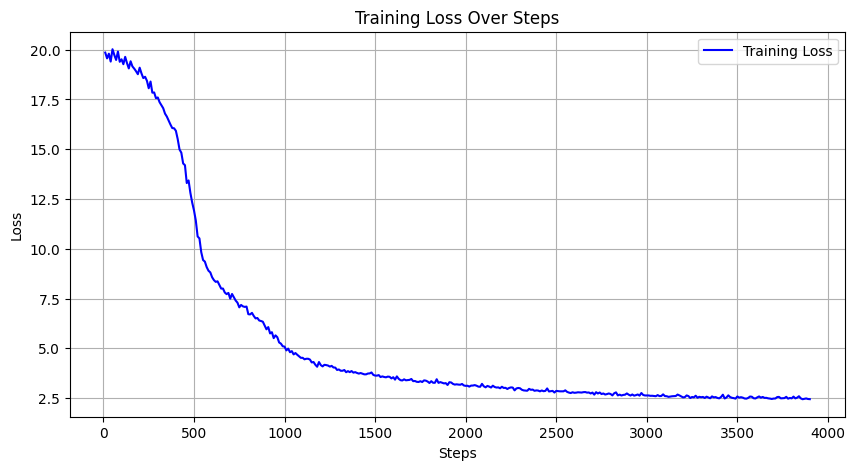

In [38]:
# 繪製訓練結果
log_history = trainer.state.log_history

# 提取步驟和損失
steps = []
losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# 繪製損失曲線
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()  # 顯示圖形

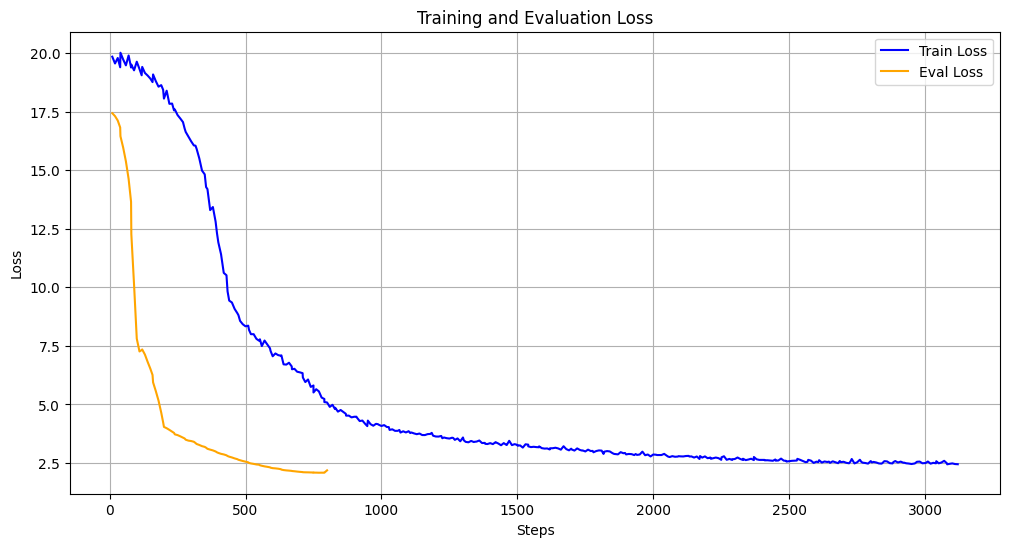

In [40]:
# 將 log_history 轉換為 DataFrame
log_history_df = pd.DataFrame(trainer.state.log_history)

# 提取訓練和驗證損失
train_losses = log_history_df['loss'].dropna().tolist()
eval_losses = log_history_df['eval_loss'].dropna().tolist()
steps = log_history_df['step'].dropna().tolist()

# 確保訓練損失和步驟匹配
train_steps = steps[:len(train_losses)]

plt.figure(figsize=(12, 6))

# 繪製訓練損失
plt.plot(train_steps, train_losses, label='Train Loss', color='blue')

# 繪製驗證損失（如果存在）
if eval_losses:
    eval_steps = steps[:len(eval_losses)]
    plt.plot(eval_steps, eval_losses, label='Eval Loss', color='orange')

plt.title('Training and Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [20]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       '../output/lora_weights', 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [21]:
peft_model.print_trainable_parameters()

trainable params: 0 || all params: 248,462,592 || trainable%: 0.0000


In [26]:
def split_text_into_chunks(text: str, chunk_size: int = 1000, overlap: int = 100):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start = end - overlap
    return chunks

def detect_has_transaction(chunk: str):
    prompt = f"classify transaction: {chunk}"
    inputs = tokenizer(prompt, max_length=512, padding="max_length", truncation=True, return_tensors="pt").to(device)
    outputs = peft_model.generate(inputs.input_ids, max_new_tokens=1)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

with open('../output/sample1.txt', 'r') as file:
    text = file.read()
    chunks = split_text_into_chunks(text)
    for chunk in chunks:
        print(chunk[:100]+'...')
        print(detect_has_transaction(chunk))

AEON CREDIT SERVICE (ASIA) CO., LTD. SAEON AEON信貸財務 (亞洲)有限公司 CREDIT SERVICE Credit Card Consolidated...


TypeError: PeftModelForSeq2SeqLM.generate() takes 1 positional argument but 2 were given